# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+

### Ход исследования

1. [Обзор данных и предобработка данных.](#start)
2. [Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии, а также для визуализации указанных метрик.](#function)
3. [Исследуем откуда приходят пользователи (страны и рекламные каналы привлечения), а также какими устройствами они пользуются.](#users_info)
4. [Разберемся какова стоимость привлечения пользователей из различных рекламных каналов, а также рассмотрим какие каналы обходятся дороже всего. Дополнительно посмотрим на картину общей окпуаемости рекламы.](#marketing)
5. [Расмотрим конверсию и удержание пользователей: общую и в зависимости от различных характеристик пользователей (используемые устройства, страна, канал привлечения).](#conversion_retention)
6. [Исследуем окупаемость в зависимости от различных характеристик пользователей (используемые устройства, страна, канал привлечения) и разберемся какие факторы приводят к убыткам.](#ltv_roi)
7. [Напишем общий вывод и рекомендации отделу рекламы.](#conclusion)

### Загрузка данных, изучение общей информации о них, предобработка данных
<a id="start"></a> 

In [1]:
#вызываем функцию игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

#импортируем необходимые библиотеки для работы
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#выгружаем файлы с данными
visits, orders, costs = (
        pd.read_csv('https://...'), # журнал сессий
        pd.read_csv('https://...'), # покупки
        pd.read_csv('https://...')   # траты на рекламу
    )
    
# посмотрим на полученные таблицы
display(visits.head(), orders.head(), costs.head())

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Преобразуем наименования столбцов всех датафреймов к стилю snake_case:

In [3]:
#приведем наименования столбцов к snake_case
#для фрейма visits
visits.columns = visits.columns.str.replace(" ", "_")
visits.columns = visits.columns.str.lower()

#для фрейма orders
orders.columns = orders.columns.str.replace(" ", "_")
orders.columns = orders.columns.str.lower()

#для фрейма costs (только к нижнему регистру)
costs.columns = costs.columns.str.lower()

#посмотрим на преобразованные наименования столбцов
display(
    visits.columns.values,
    orders.columns.values,
    costs.columns.values
)

array(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'], dtype=object)

array(['user_id', 'event_dt', 'revenue'], dtype=object)

array(['dt', 'channel', 'costs'], dtype=object)

Стиль наименования столбцов теперь соблюден. Посмотрим на информацию о датафреймах:

In [4]:
#получим информацию о датафрейме users
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
#получим информацию о датафрейме orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
#получим информацию о датафрейме costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Во всех фреймах отсутствуют пропуски. При этом там, где отображены даты, тип данных указан неверный (object  вместо datetime). Преобразуем их к соответствующему типу данных:

In [7]:
# преобразование данных о времени

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Типы данных преобразовали.

Осуществим проверку на явные дубликаты:

In [8]:
#проверка на явные дубликаты
display(
    visits.duplicated().sum(),
    orders.duplicated().sum(),
    costs.duplicated().sum()
)

0

0

0

Явные дубликаты отсутствуют.

Можно приступать к следующему шагу.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии, а также функции для построения графиков
<a id="function"></a> 

#### Сперва соберём функции для создания профилей, расчёта удержания, конверсии, LTV и ROI:
- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles 

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Теперь соберем функции для визуализации (построения графиков) перечисленных выше метрик:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследуем откуда приходят пользователи (страны и рекламные каналы привлечения), а также какими устройствами они пользуются:
<a id="users_info"></a> 

#### Составим профили пользователей и определим минимальную и максимальную даты их привлечения:

In [17]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)


#выведем первые 5 строк фрейма пользовательских профилей, а также min и max даты их привлечения 
display(
    profiles.head(),
    'Минимальная дата привлечения пользователей {}'.format(profiles['first_ts'].min()),
    'Максимальная дата привлечения пользователей {}'.format(profiles['first_ts'].max()) 
)

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

'Минимальная дата привлечения пользователей 2019-05-01 00:00:41'

'Максимальная дата привлечения пользователей 2019-10-27 23:59:04'

**Вывод:** минимальная и максимальная даты привлечения соответствуют анонсированным датам, в рамках которых выгружены данные о пользователях.

#### Выясним из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны:

In [18]:
#сгруппируем пользовательские профили по странам
profiles.groupby('region'
    ).agg({'user_id': 'nunique', 'payer': 'mean'} #посчитаем кол-во пользователей и долю платящих пользователей в каждой стране
    ).rename(columns = {'user_id': 'users'}
    ).sort_values(by = 'payer', ascending = False)

users     payer
region                         
United States  100002  0.069019
Germany         14981  0.041119
UK              17575  0.039829
France          17450  0.037994

Пользователями приложения являются жители США, Англии, Франции и Германии.

**Вывод:** Наибольшая доля платящих пользователей расположена в США (6,9%), а наименьшая - во Франции (3,7%).

При этом больше всего пользователей приходит также из США (100 тыс.), но меньше всего - из Германии (14 тыс.).

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства:

In [19]:
#сгруппируем пользовательские профили по используемым устройствам
profiles.groupby('device'
    ).agg({'user_id': 'nunique', 'payer': 'mean'} #посчитаем кол-во пользователей и долю платящих с каждого устройства
    ).rename(columns = {'user_id': 'users'}
    ).sort_values(by = 'payer', ascending = False)

users     payer
device                  
Mac      30042  0.063644
iPhone   54479  0.062079
Android  35032  0.058518
PC       30455  0.050468

Пользователи приложения для входа в него используют iPhone, Android, персональный компьтер, а также Mac.

**Вывод:** больше всего пользователи оплачивают покупки с таких устройств как Mac (6,3%) и iPhone (6,2%).

При этом по количеству пользователей данным приложением являются владельцы iPhone (54 тыс.), а вот количество владельцов Mac, использующих  приложение, в большом отрыве от iPhone (30 тыс.).

#### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.

Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения:

In [20]:
#сгруппируем пользовательские профили по каналам привлечения
profiles.groupby('channel'
    ).agg({'user_id': 'nunique', 'payer': 'mean'} #посчитаем кол-во пользователей и долю платящих для каждого канала
    ).rename(columns = {'user_id': 'users'}
    ).sort_values(by = 'payer', ascending = False
    ).reset_index(
    ).style.format({'payer': '{:.1%}'}
    )



Всего 11 каналов привлечения.

**Вывод:** наибольшее количество платящих пользователей приходит из FaceBoom (12,2%) и естественно, что меньше всего платящих пользователей из канала organic (2,1%). Наименьшее количество пользователей среди платных каналов приходится на OppleCreativeMedia (2,7%).

При этом больше всего пользовтелей приложением как раз из канала organic (56 тыс.), затем уже из FaceBoom (29 тыс.) и на 3-м месте из TipTop (19 тыс.).

### Исследуем какова стоимость привлечения пользователей из различных рекламных каналов
<a id="marketing"></a> 

#### Посчитаем общую сумму расходов на маркетинг:

In [21]:
'Общая сумма расходов на маркетинг в период с 1 мая 2019 г. по 27 октября 2019 г. составила {}.'.format(costs['costs'].sum())

'Общая сумма расходов на маркетинг в период с 1 мая 2019 г. по 27 октября 2019 г. составила 105497.30000000002.'

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник:

In [22]:
#сгруппируем информацию о расходах на рекламу по каналам привлечения
costs.groupby(
    'channel'
    ).agg({'costs': 'sum'} #и посчитаем сумму затрат, вложенных в рекламу в каждом из каналов привлечения
    ).sort_values(by = 'costs', ascending = False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Больше всего вложений пришлось на канал TipTop (54 тыс.), а доля привлеченных **платящих** пользователей с него (10%) меньше, чем от канала FaceBoom (доля платящих - 12%, траты составили 32 тыс., 2-е место по рекламным вложениям), исходя из чего уже можно предположить, что, возможно по этому каналу проседает окупаемость, но посмотрим это в ходе исследования.

Кроме того эти 2 канала имеют колоссальный отрыв по затратам на рекламу в отличие от других каналов.

### Визуализируем динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику:

In [23]:
#создадим дополнительные столбцы в датафрейме с расходами и поместим туда номера недель и месяцев,
#в которых были осуществлены вложения в рекламу
costs['dt'] = pd.to_datetime(costs['dt'])
costs['costs_week'] = costs['dt'].astype('datetime64[W]') #определяем номер недели в доп. столдбце
costs['costs_month'] = costs['dt'].astype('datetime64[M]') #определяем номер месяца в доп. столдбце

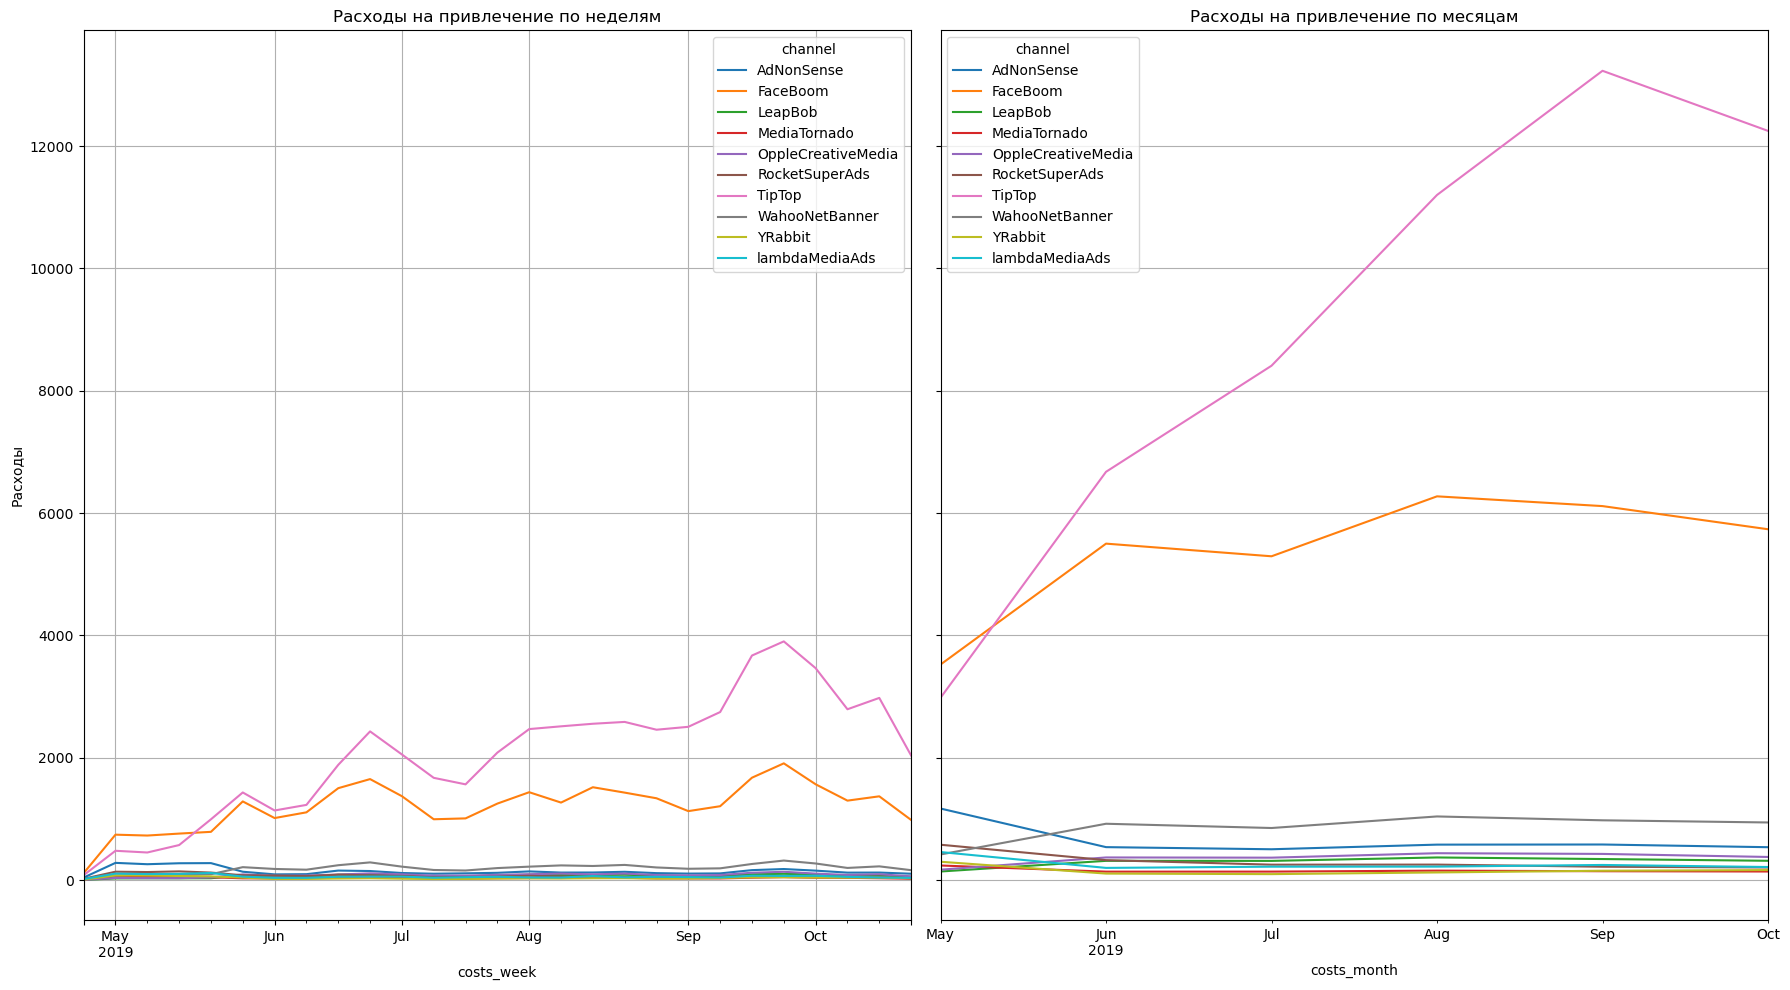

In [24]:
# задаём размер сетки для графиков
plt.figure(figsize=(18, 10))

#первый график динамика расходов по неделям
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(
    index='costs_week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax = ax1)
plt.ylabel('Расходы')
plt.title('Расходы на привлечение по неделям')

#второй график динамика расходов по неделям
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
costs.pivot_table(
    index='costs_month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax = ax2)
plt.ylabel('Расходы')
plt.title('Расходы на привлечение по месяцам')

plt.tight_layout()
plt.show()

Как и в таблице с общими затратами по каждому каналу, больше всего понедельно и помесячно расходов приходится на канал TipTop, а затем на FaceBoom, а также, именно эти каналы имеют самые большие затраты в отличие от других каналов привлечения. При этом видно, что в начале мая затраты на FaceBoom были чуть выше, чем на TipTop.

Кроме того, заметен синхронный рост и спад затрат для каналов TipTop и FaceBoom из неделю в неделю или из месяца в месяц.

По остальным каналам затраты на рекламу деражатся приблизтельно на одном уровне.

#### Определим сколько в среднем стоило привлечение одного пользователя из каждого источника:

In [25]:
profiles.groupby(
    'channel'
    ).agg({'acquisition_cost': 'mean'}
    ).rename(columns = {'acquisition_cost': 'acquisition_cost_per_channel'}
    ).sort_values(by = 'acquisition_cost_per_channel', ascending = False
    )

acquisition_cost_per_channel
channel                                         
TipTop                                  2.799003
FaceBoom                                1.113286
AdNonSense                              1.008054
lambdaMediaAds                          0.724802
WahooNetBanner                          0.602245
RocketSuperAds                          0.412095
OppleCreativeMedia                      0.250000
YRabbit                                 0.218975
MediaTornado                            0.218717
LeapBob                                 0.210172
organic                                 0.000000

Как и во всех анализах выше - самые высокие средние затраты для привлечения одного пользователя приходятся на канал TipTop - 2.8, затем на FaceBoom - 1.11. Третьим по удельным затратам занимает место канал AdNonSense - 1.01, по всем остальным каналам удельные траты на привлечение одного пользователя составляют 0.72 и ниже.

**Выводы:**

Общая сумма затрат в рекламу в рассматриваемый период (с 01.05.2019 по 27.10.2019) составляет 105,5 тыс. у.е.

Больше всего затрат приходится на рекламу в каналах TipTop и FaceBoom - это подтверждается и по общему объему затрат в каждый канал привлечения, и по динамике затрат по неделям и месяцам, а также по удельным затратам на одного клиента.

Кроме того, указанные выше каналы имеют большой отрыв по затратам от всех остальных каналов - на них приходится около 82% всех затрат.

Рекламные вложения по сотальным каналам приблизительно одинаковые.

По каналу привлечения пользователей organic траты отсутствуют, как и должно быть.

### Оценим окупаемость рекламы

Установим момент и горизонт анализа данных. Отчетной датой будет 1 ноября 2019 года. Горизонт анализа зададим 2 недели, т.к. бизнес-планом заложена окупаемость клиентов не позднее указанного периода.

Также нужно будет понять стоит ли оставить органических пользователей.

In [26]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

**Посчитаем бизнес-показатели.**

#### Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы.

Для этого рассчитаем и визуализируем LTV, ROI и CAC, в т.ч. в динамике, вызвав функции get_ltv() и plot_ltv_roi(). 

Сперва произведем расчет указанных метрик с учетом органических пользователей:

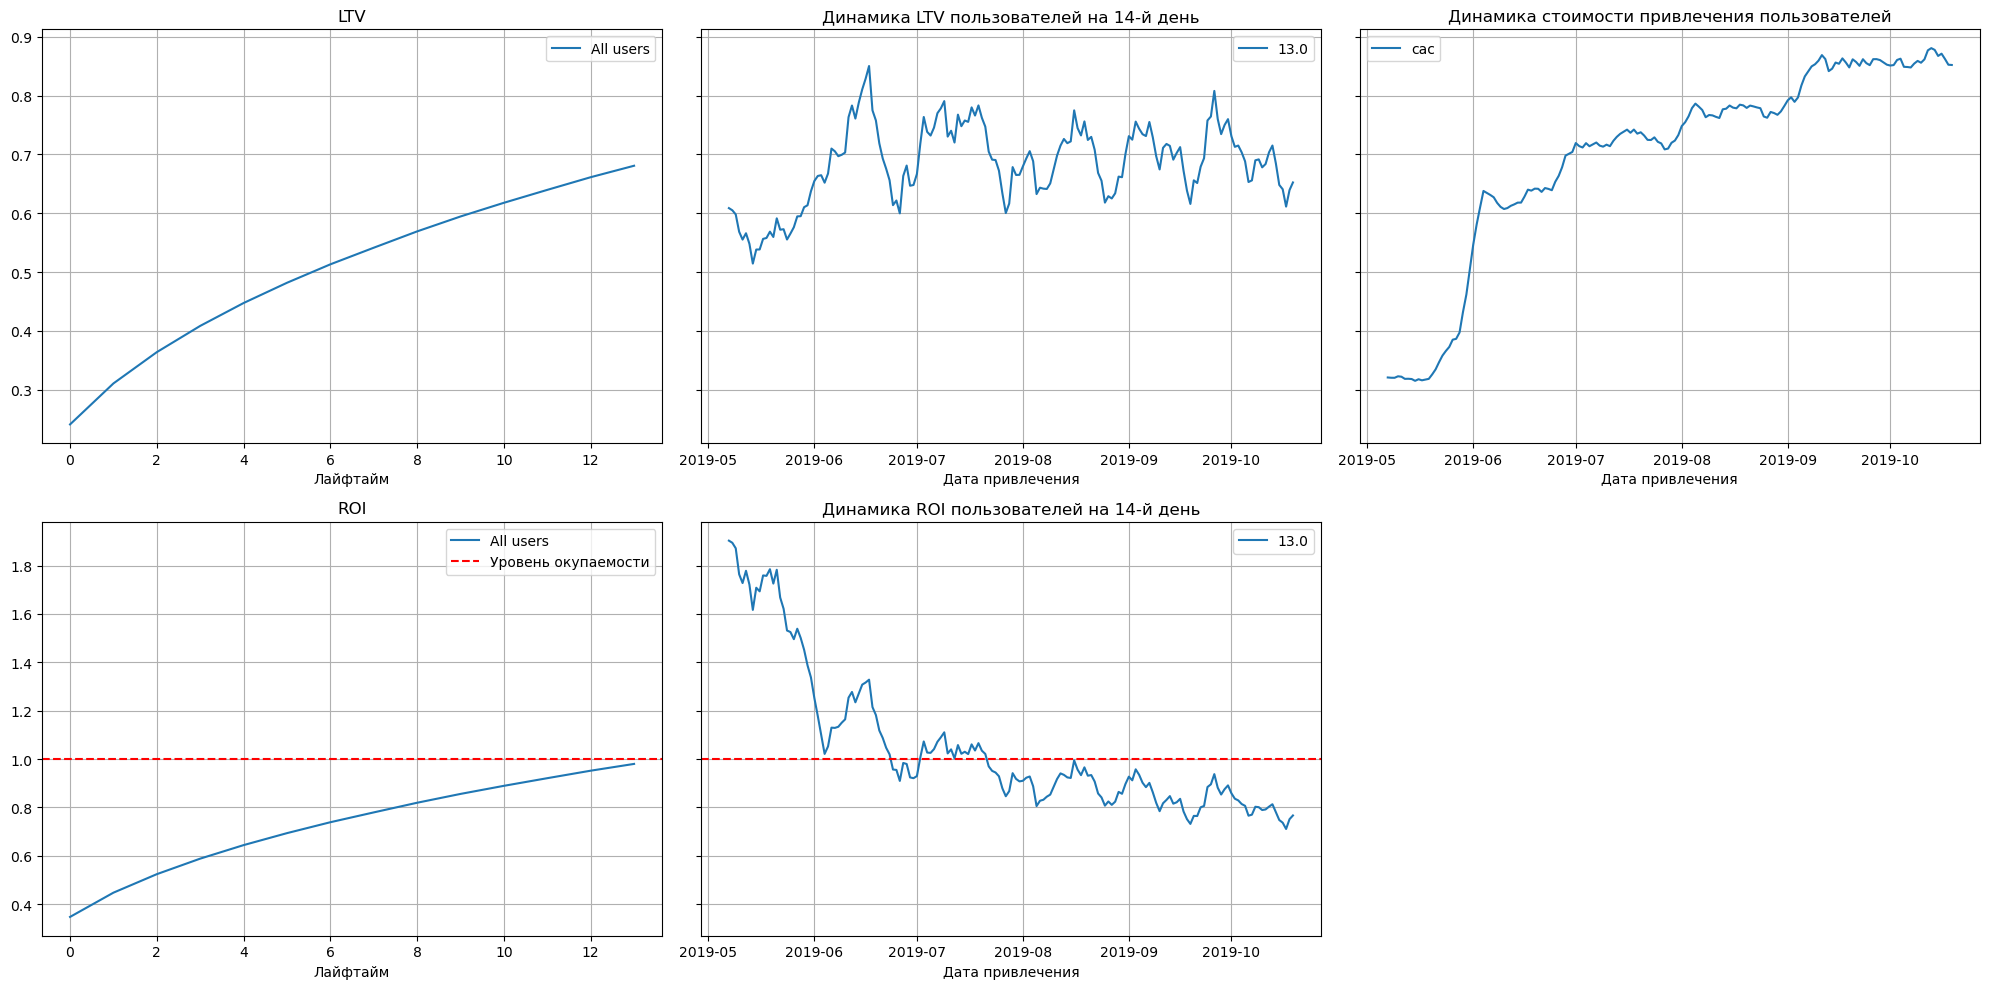

In [27]:
# считаем LTV и ROI с учетом органических пользователей
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики с учетом органических пользователей
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать следующие выводы:

* Реклама не окупается. ROI в конце заложенного периода окупаемости совсем немного не хватает до 100%. Видно, что в период с мая по почти конец июля затраты на рекламу успевали окупаться за 14 дней.
* LTV на протяжении всего лайфтайма растет, что означает, что в расчетах нет ошибок. В среднем уровень LTV на конец второй недели стабильно составляет около 0,7.
* Затраты на рекламу из месяца в месяц растут: в августе затраты приблизительно сравнялись с выручкой, а уже, начиная где-то с сентября, они стабильно выше выручки и состаляют около 0,9. Вспоминая анализ по каналам привлечения, именно с августа был заметен существенный рост в каналы FaceBoom и TipTop, особенно в TipTop.

Теперь сделаем расчет тех же метрик, но уже без органических пользователей:

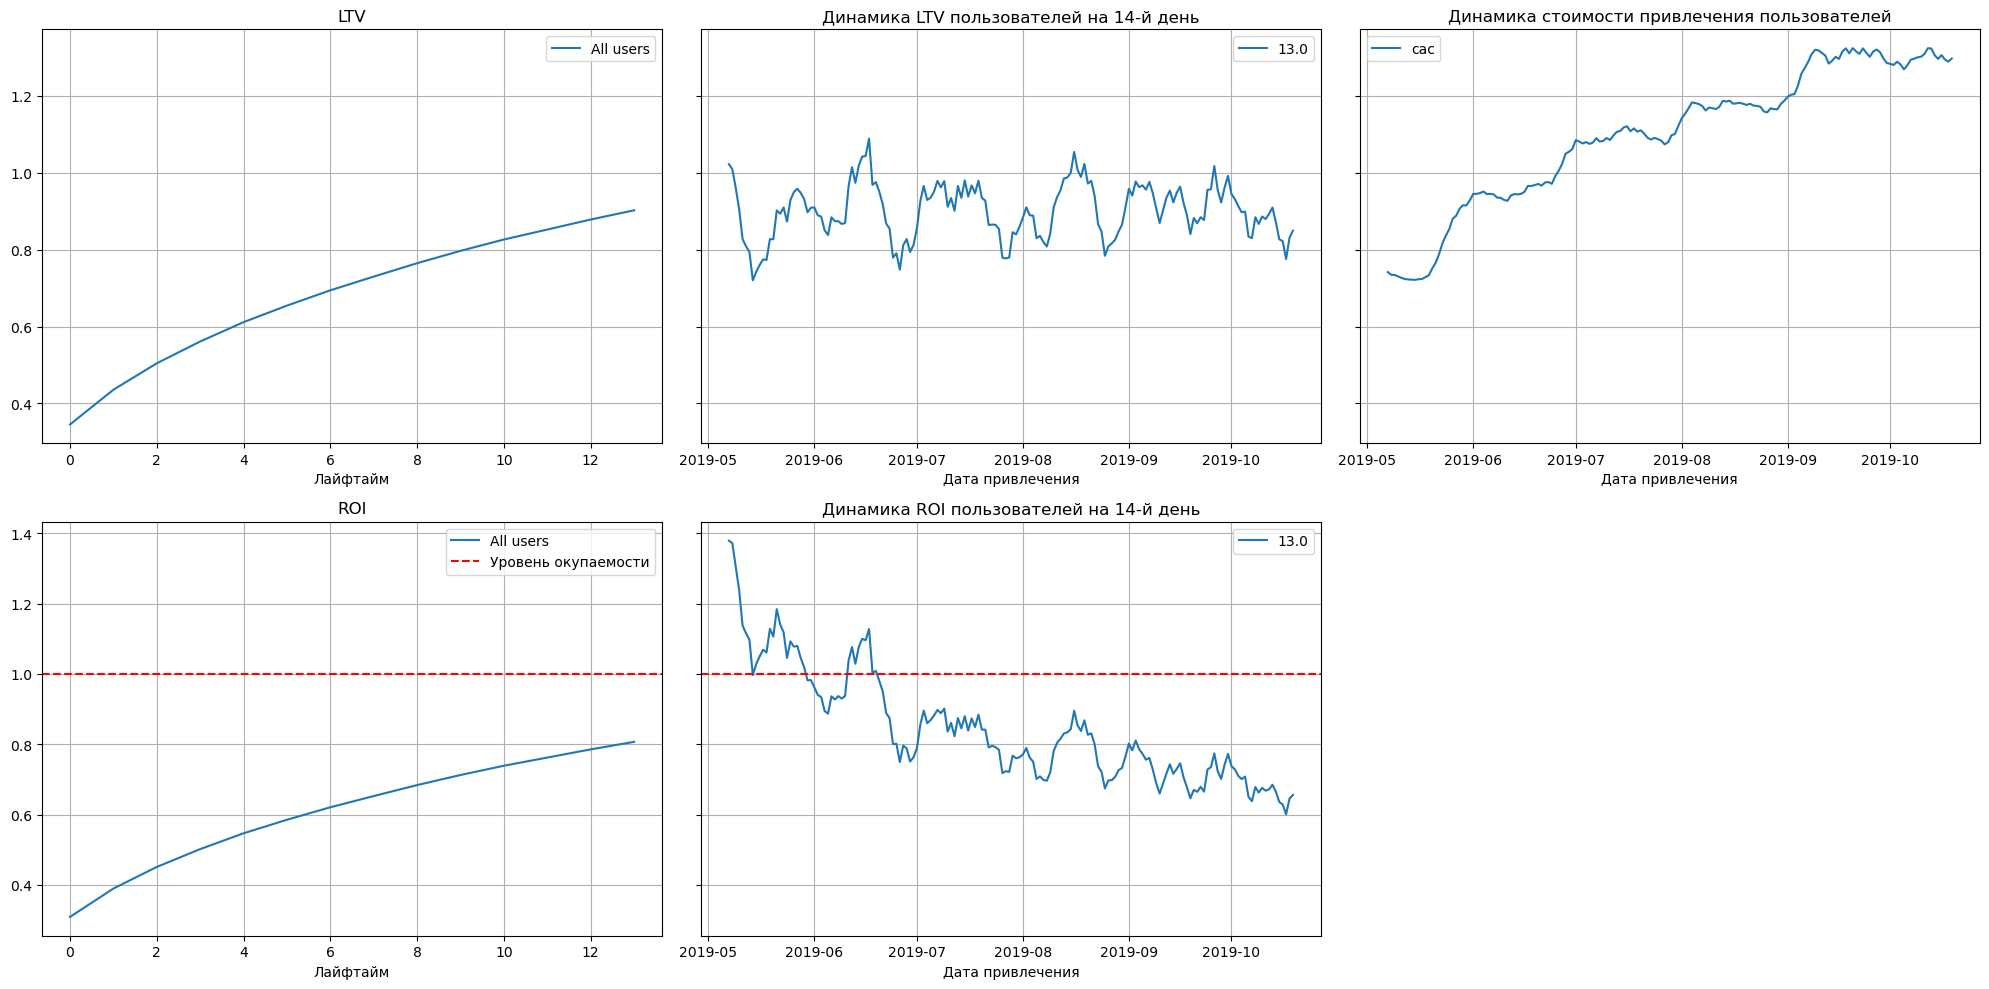

In [28]:
# считаем LTV и ROI без органических пользователей
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days
)

# строим графики по данным без органических пользователей
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days) 

Без органичеких пользователей картина выглядит хуже:
* может, LTV и выше (т.к. платные клиенты и больше по качеству ориентированы на покупки), но и затраты тоже выше, поэтому, можно сказать, что этот рост LTV нивелирован.
* без органических пользователей окупаемость очень упала и достигает к концу 2-й недели чуть больше 80%.
* динамика окупамости из месяца в месяц начала падать еще раньше, чем с органическими пользователями и уже, начиная с июня вложения не окупаются (с учетом органических пользователей это начиналось почти с июля).

Это вполне объяснимо, ведь органические пользователи не требуют затрат на их привлечение, но при этом приносят доход, хоть и небольшой, но все же приносят.

**Для дальнейшего исследования все же будем пользоваться данными без органических пользователей, чтобы соблюсти всю строгость к окупаемости вложений, а органические пользователи будут просто приятным бонусом для добивки окупаемости.**

### Анализ конверсии пользователей и динамики их ужержания:
<a id="conversion_retention"></a> 

#### Проверим конверсию пользователей и динамику её изменения.

Вызовем функции get_conversion() и plot_conversion(), чтобы рассчитать и отразить на графиках этот показатель.

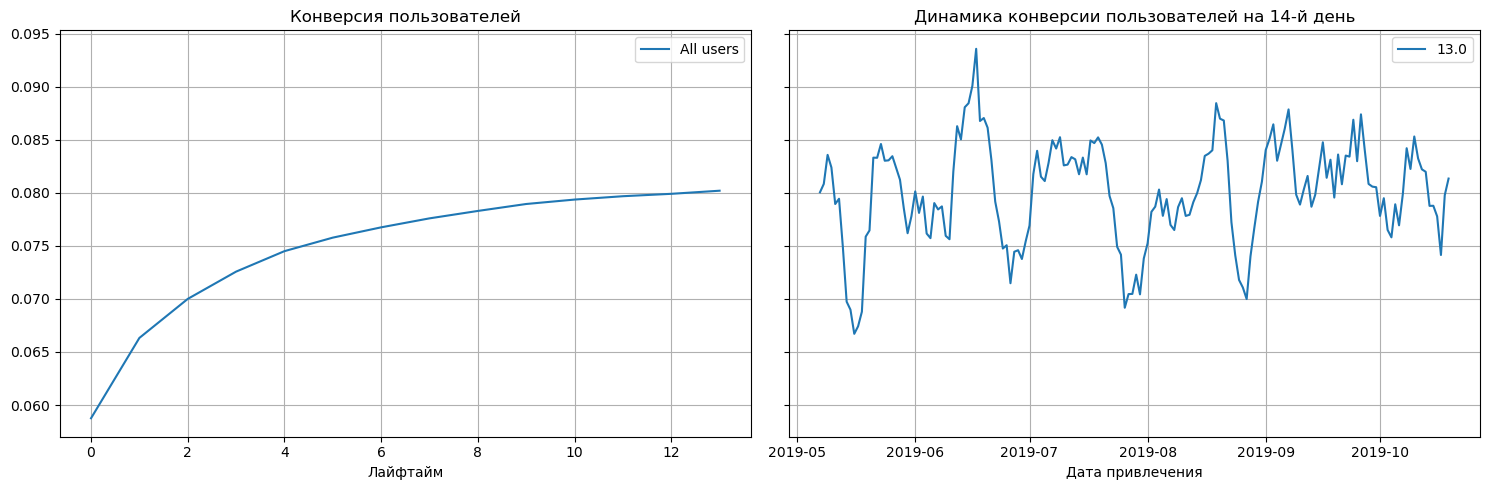

In [29]:
# смотрим конверсию без органических пользователей (query('channel != "organic"'))
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия с 10 по 14 дни лайфтайма приблизительно на одном уровне.

Динамика конверсии на конец 2-й недели в середине мае была довольно низкая, в середине июня она достигла пикового значения и затем в среднем держалась приблизительно на одном уровне около 8%. И даже, начиная с середины сентября конверсия наоборот перестала иметь такой большой разброси в динамике, особенно на спад.

Поэтому, судя по графикам, пользователи конвертируются нормально, причём постоянно. 

Может быть, дело в удержании.

К удержанию перейдем чуть позже, а пока продолжим ислледование конверсий в зависимости от характеристик пользователей.
 
**Сперва рассмотрим конверсию в разбивке по устройствам:**

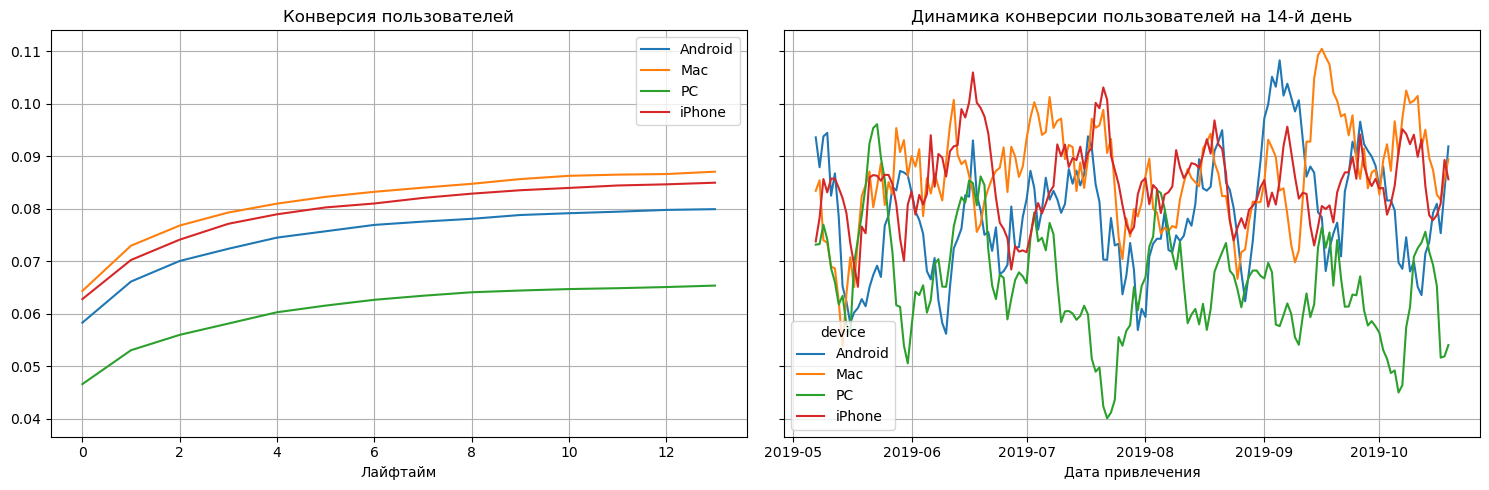

In [30]:
# смотрим конверсию в зависимости от используемого устройства
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Самая низкая конверсия у пользователей устройств PC (около 6% к концу лайфтайма), а самая высокая у пользователей продукции IOS (порядка 8,5% к концу лайфтайма). Ранее мы также отмечали, что больше всего платящих пользователей как раз тоже среди пользователей использующих продукцию Apple.

**Теперь посмотрим конверсию в разрезе стран:**

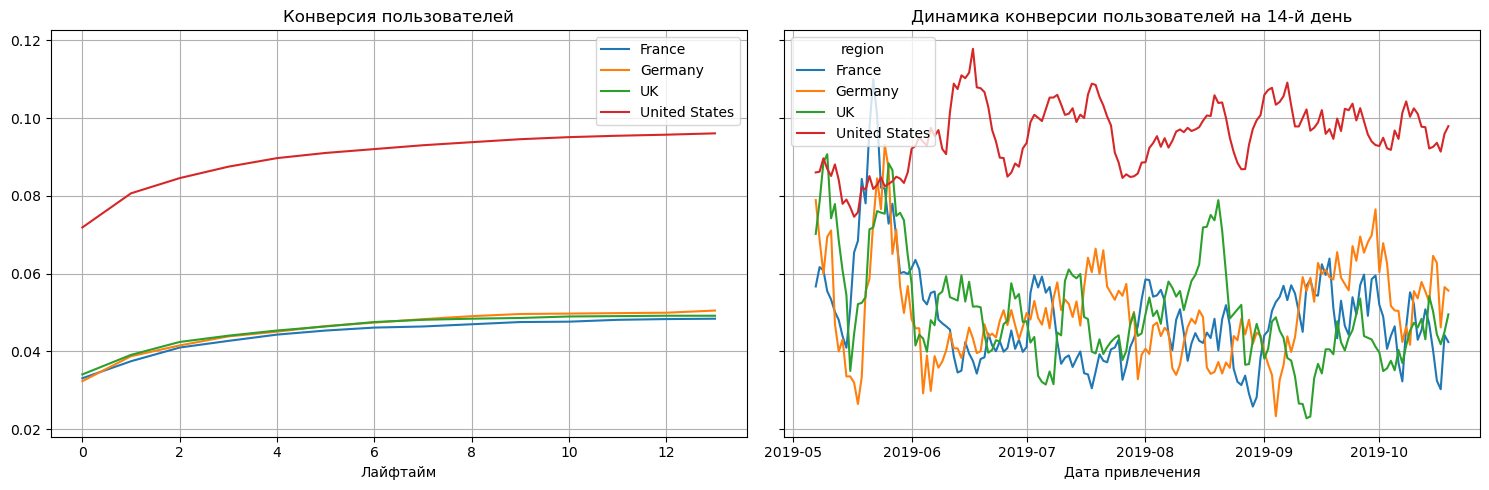

In [31]:
# смотрим конверсию в зависимости от региона
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Самая высокая конверсия у пользователей США - 10% на конец лайфтайма, которые как раз, как правило, в основном используют продукцию компании Apple. У остальных стран конверсия приблизительно на одном уровне и составляет на 14-й день лайфтайма около 4,5%.

**Рассмотрим конверсию в зависимости от канала привлечения пользователей:**

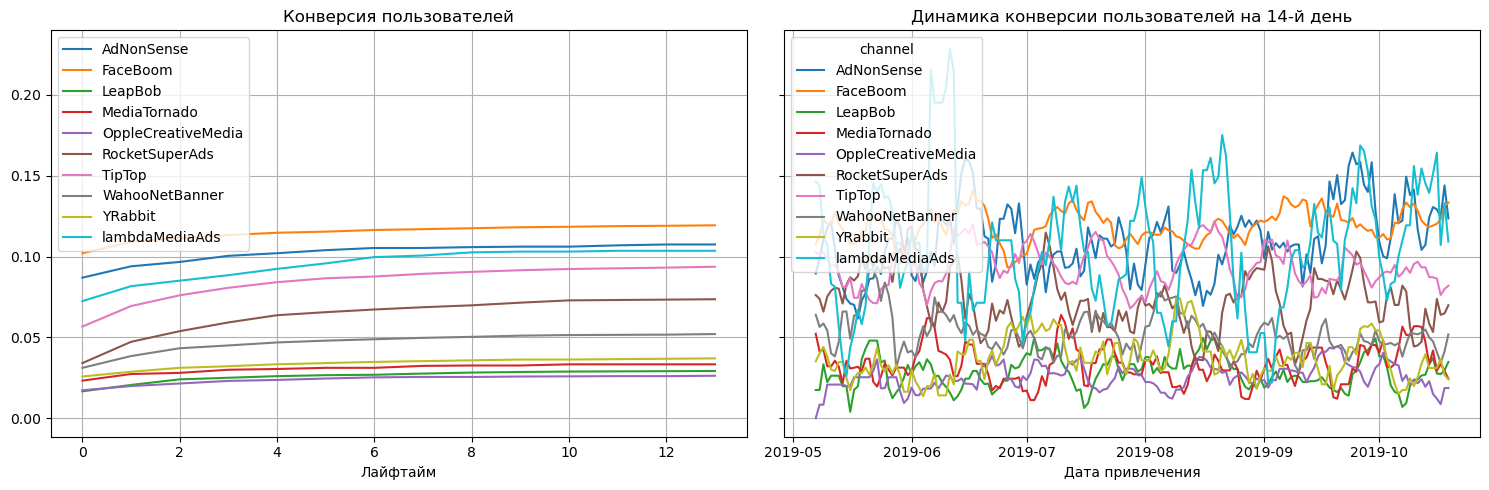

In [32]:
# смотрим конверсию в зависимости от канала привлечения пользователей
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Хорошая конверсия от следующих каналов привлечения пользователей:
* FaceBoom (приблизительно 13%)
* AdNonSense (около 12%)
* lambdaMediaAds (около 11%)
* TipTop (почти 9%).

В целом конверсия по всем каналам привлечения стабильна с учетом сезонности.

**Общая картина по конверсии - довольно неплохая, нельзя сказать, что где-то сильные провалы. Особенно стоит отметить высокую конверсию у пользователей, которые используют устройства Apple, преимущественно из США и привлечены из каналов FaceBoom, AdNonSense, lambdaMediaAds и TipTop.**

#### Теперь пройдемся по удержанию пользователей и динамику его изменения.

Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

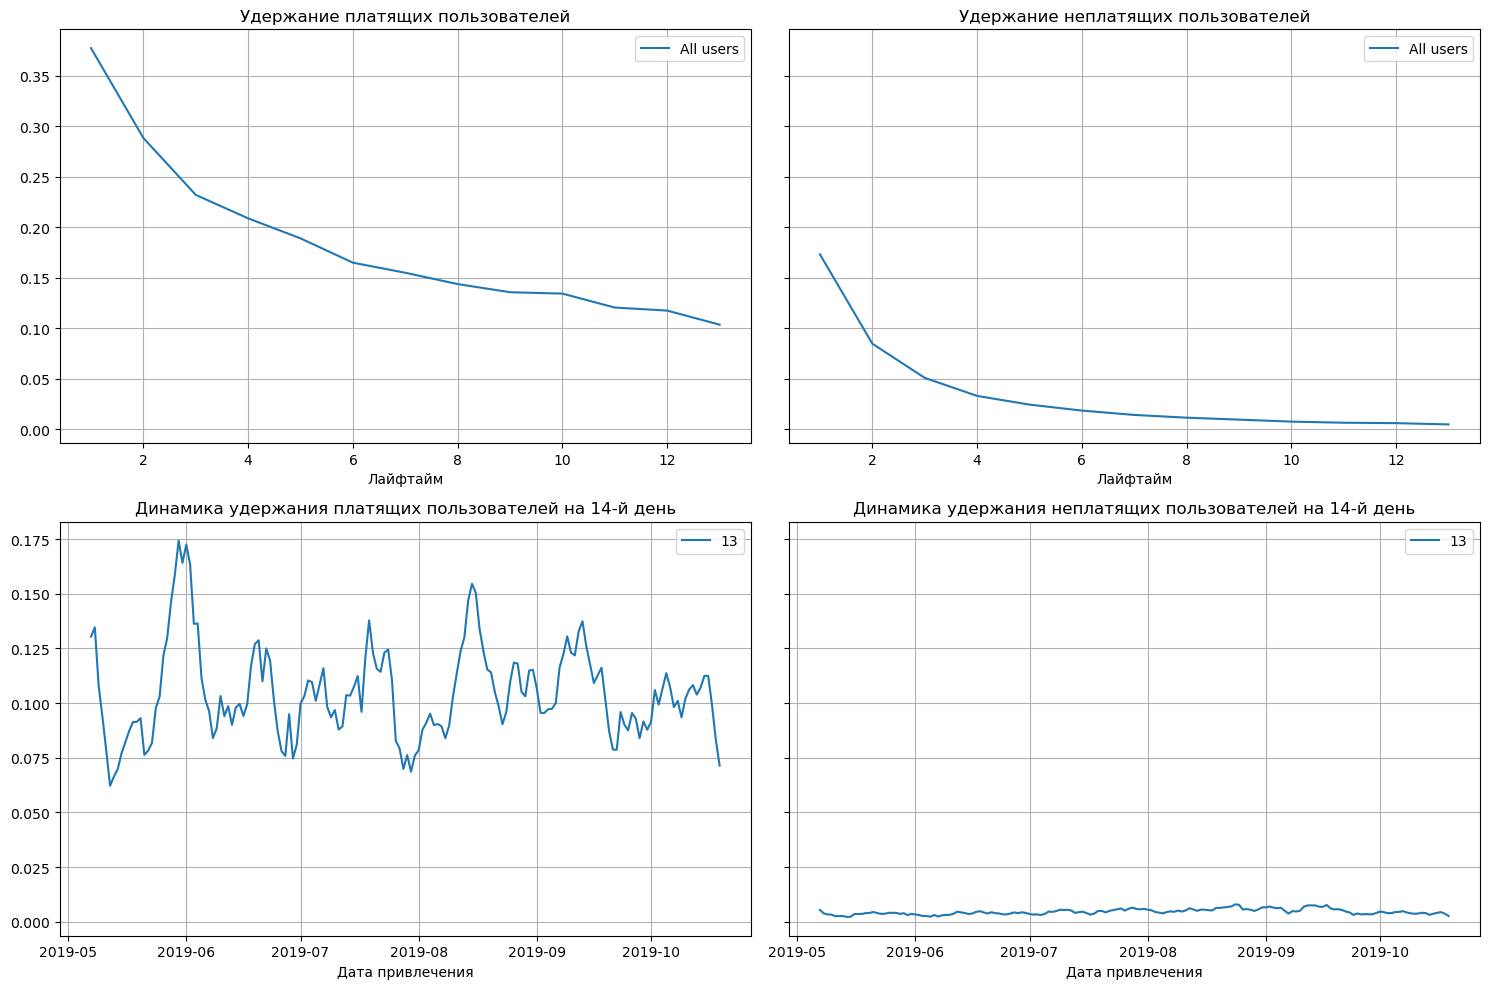

In [33]:
# смотрим удержание без органических пользователей (query('channel != "organic"'))

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits.query('channel != "organic"'), observation_date, horizon_days
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам видно, что удержание довольно неплохое и ожидаемое при нормальном раскладе:
* уровень удержания пользователей к концу 2-й недели составляет 10%.
* уровень удержания платящих пользователей выше, чем тех, которые не платят.
* динамика удержания платящих пользователей тоже приблизительно стабильна и в среднем держится на уровне 10%.
* **но все же в динамике удержания платных пользователей в конце рассматриваемого периода заметен спад, начиная с середины сентября и до конца рассматриваемого периода относительно остальных месяцев.**

**Поэтому следует рассмотреть удержание пользователей по различным признакам.**

**Начнем с разбивки по устройствам:**

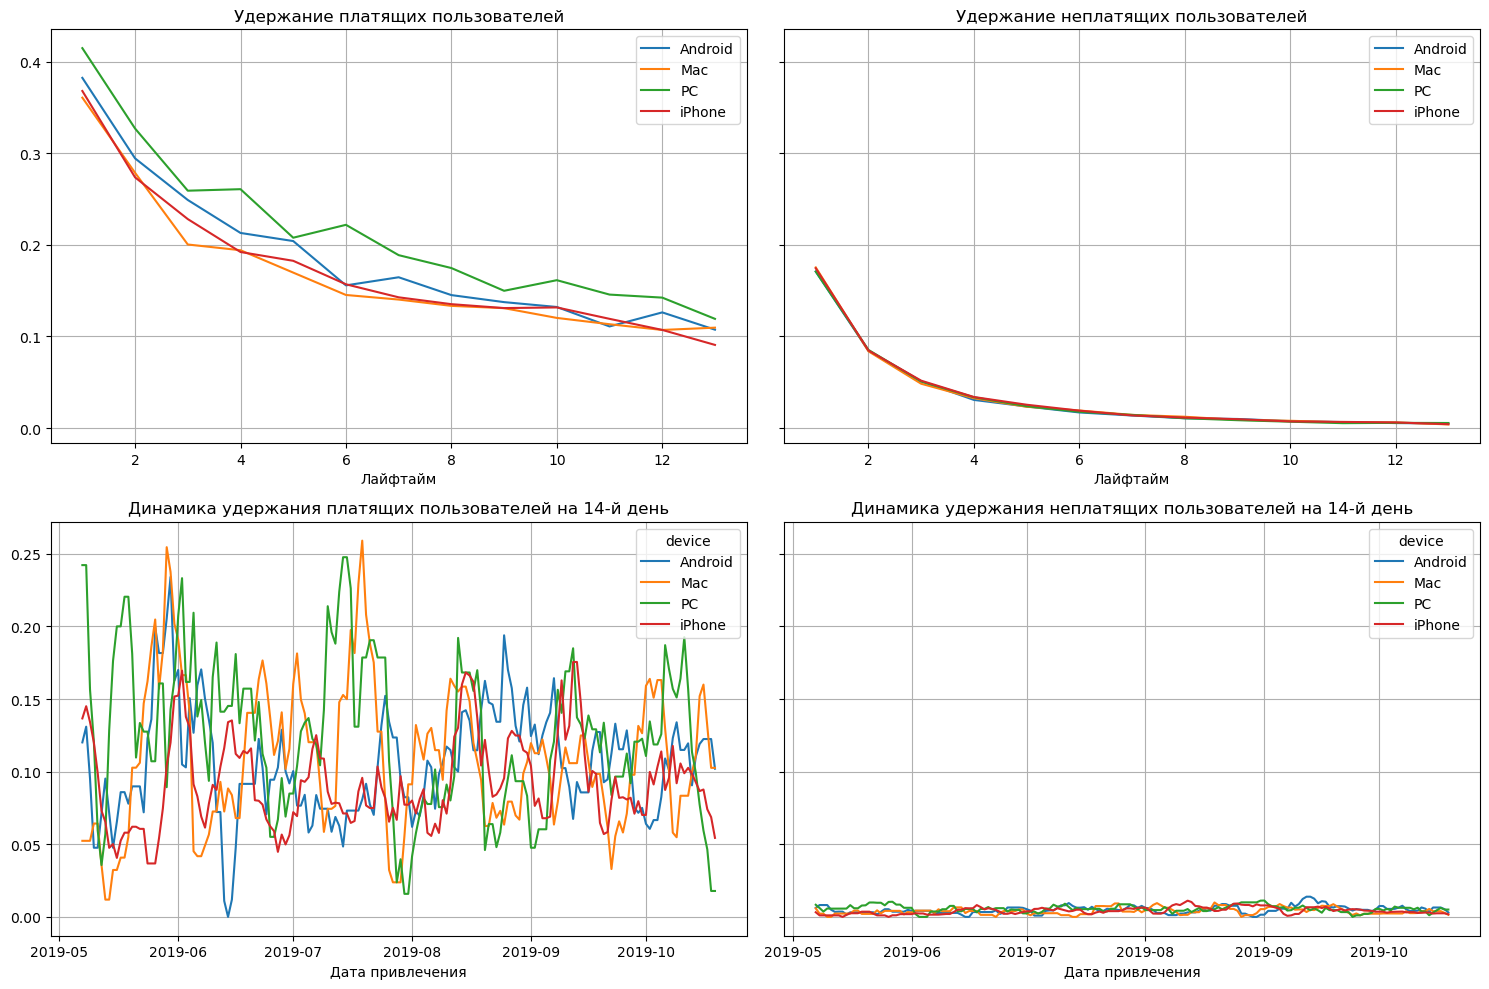

In [34]:
# смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'),
    visits.query('channel != "organic"'),
    observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

Относительно используемых устройств к концу 14-го дня удержание падает равномерно и нет выдающихся значений.

А если говорить о динамеке удержания, то она тоже циклична для каждого из устройств и даже можно отметить, что начиная с середины августа у нее уменьшился разброс по значениям.

То есть дело не в устройствах.

Удержание неплатящих пользователей стабильно и ничем не примечательно.

**Теперь рассмотрим удержание в разрезе стран:**

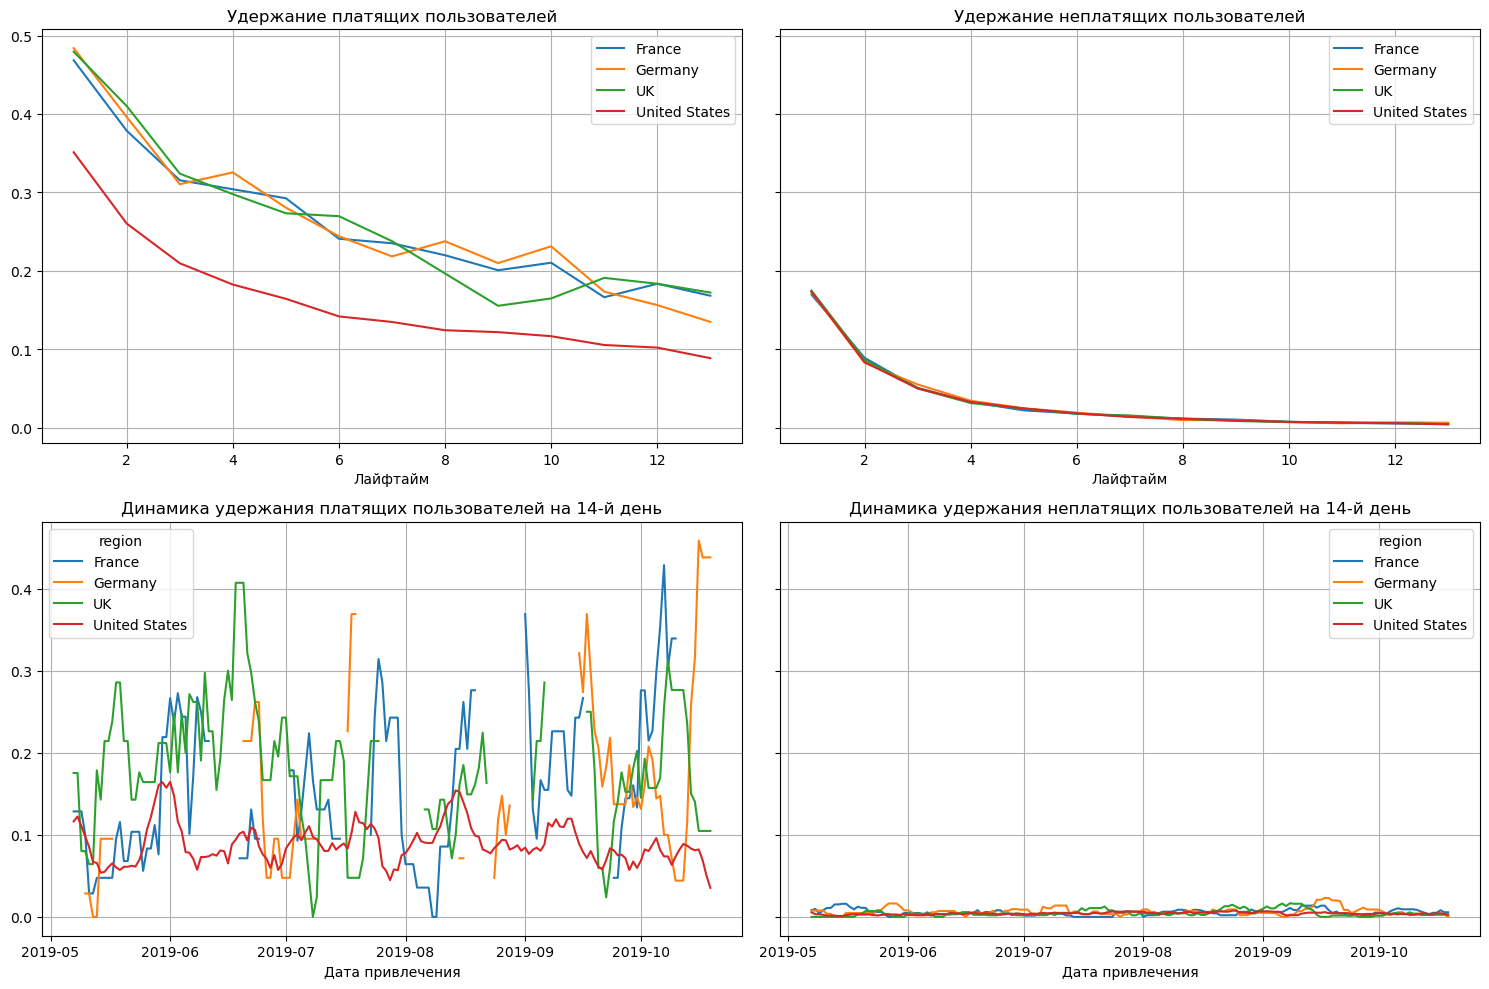

In [35]:
# смотрим удержание с разбивкой по странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'),
    visits.query('channel != "organic"'),
    observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

В разбивке по странам сразу можно отметить, что довольно низкое удержание платящих пользователей из США, а вот пользователи из Германии увеличили показатель удержания к концу рассматриваемого периода.

Но тут тоже нет явных проблем.

Удержание неплатящих пользователей стабильно и ничем не примечательно.

**Рассмотрим удержание в разрезе каналов привлечения пользователей:**

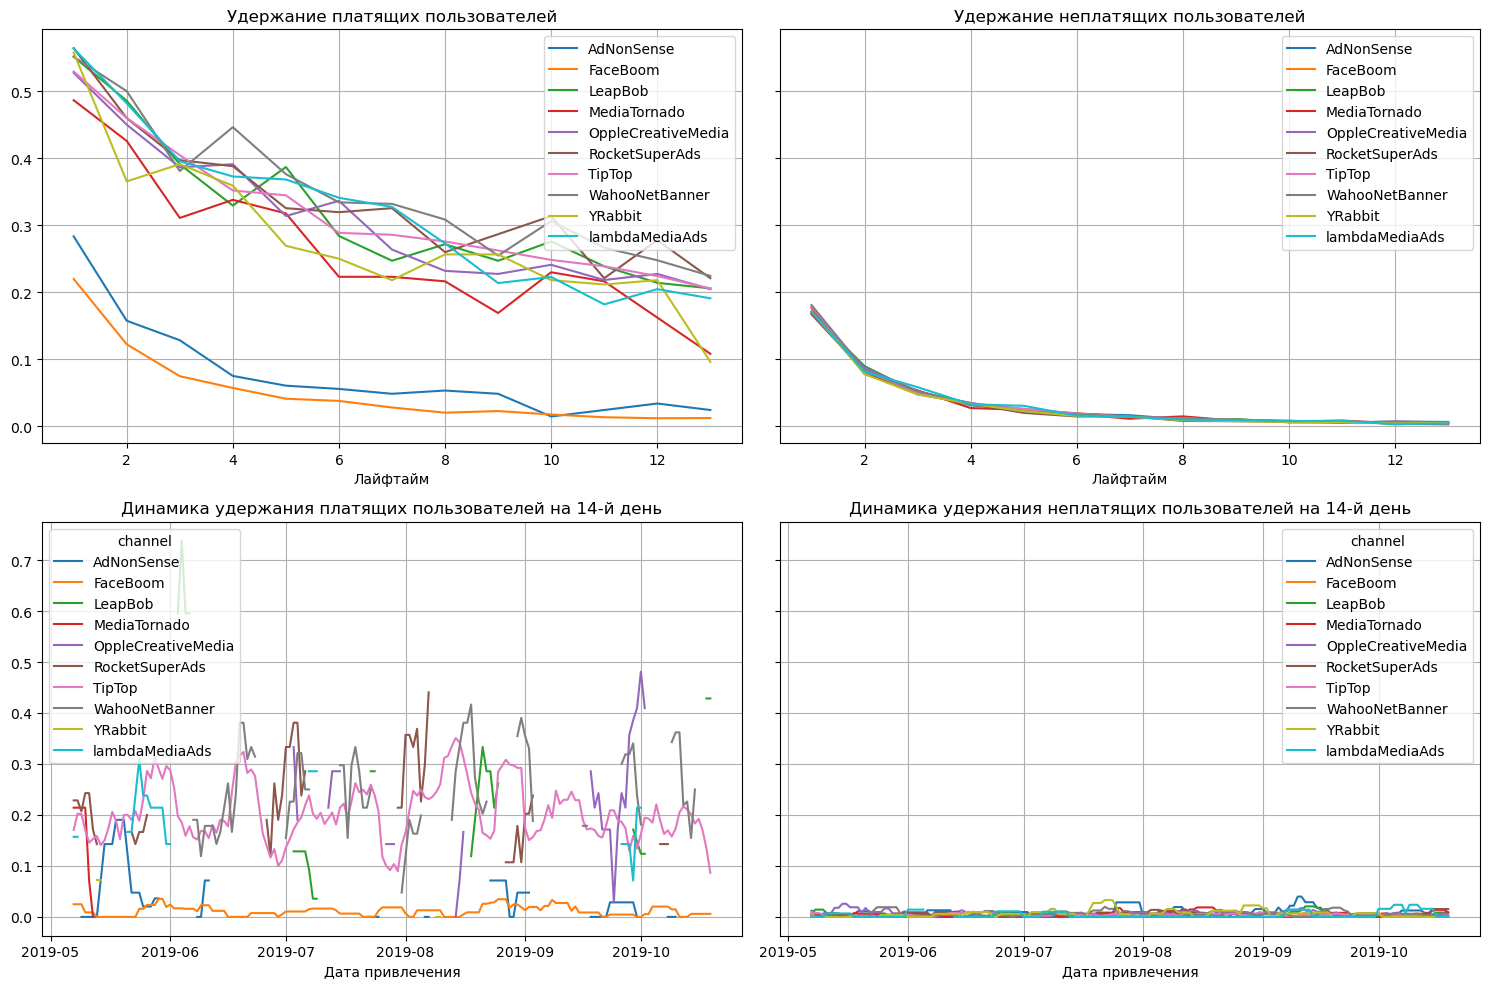

In [36]:
# смотрим удержание с разбивкой по каналам привлечения
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'),
    visits.query('channel != "organic"'),
    observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

С большим разрывом ото всех остальных каналов привлечения пользователей очень низкое удержание по 2-м каналам: FaceBoom и AdNonSense (не достигает даже 10%, в то время как по всем остальным удержание в пределах от 10 до 50%). При этом, можно вспомнить, что канал FaceBoom идет второй по размеру вложений в рекламу.

Кроме того, по каналу TipTop (1-е место по объему затрат на рекламу) видно, как в динамике, начиная с сентября, у него стабильно падает удержание платящих пользователей.

Удержание неплатящих пользователей по всем каналам стабильно и ничем не примечательно.

Перейдем теперь снова к показателю окупаемости уже в разрезе от той или иной характеристики.

### Анализ окупаемости в зависимости от различных характеристик пользователей (используемые устройства, страна, канал привлечения):
<a id="ltv_roi"></a> 

#### Анализ окупаемости рекламы с разбивкой по устройствам:

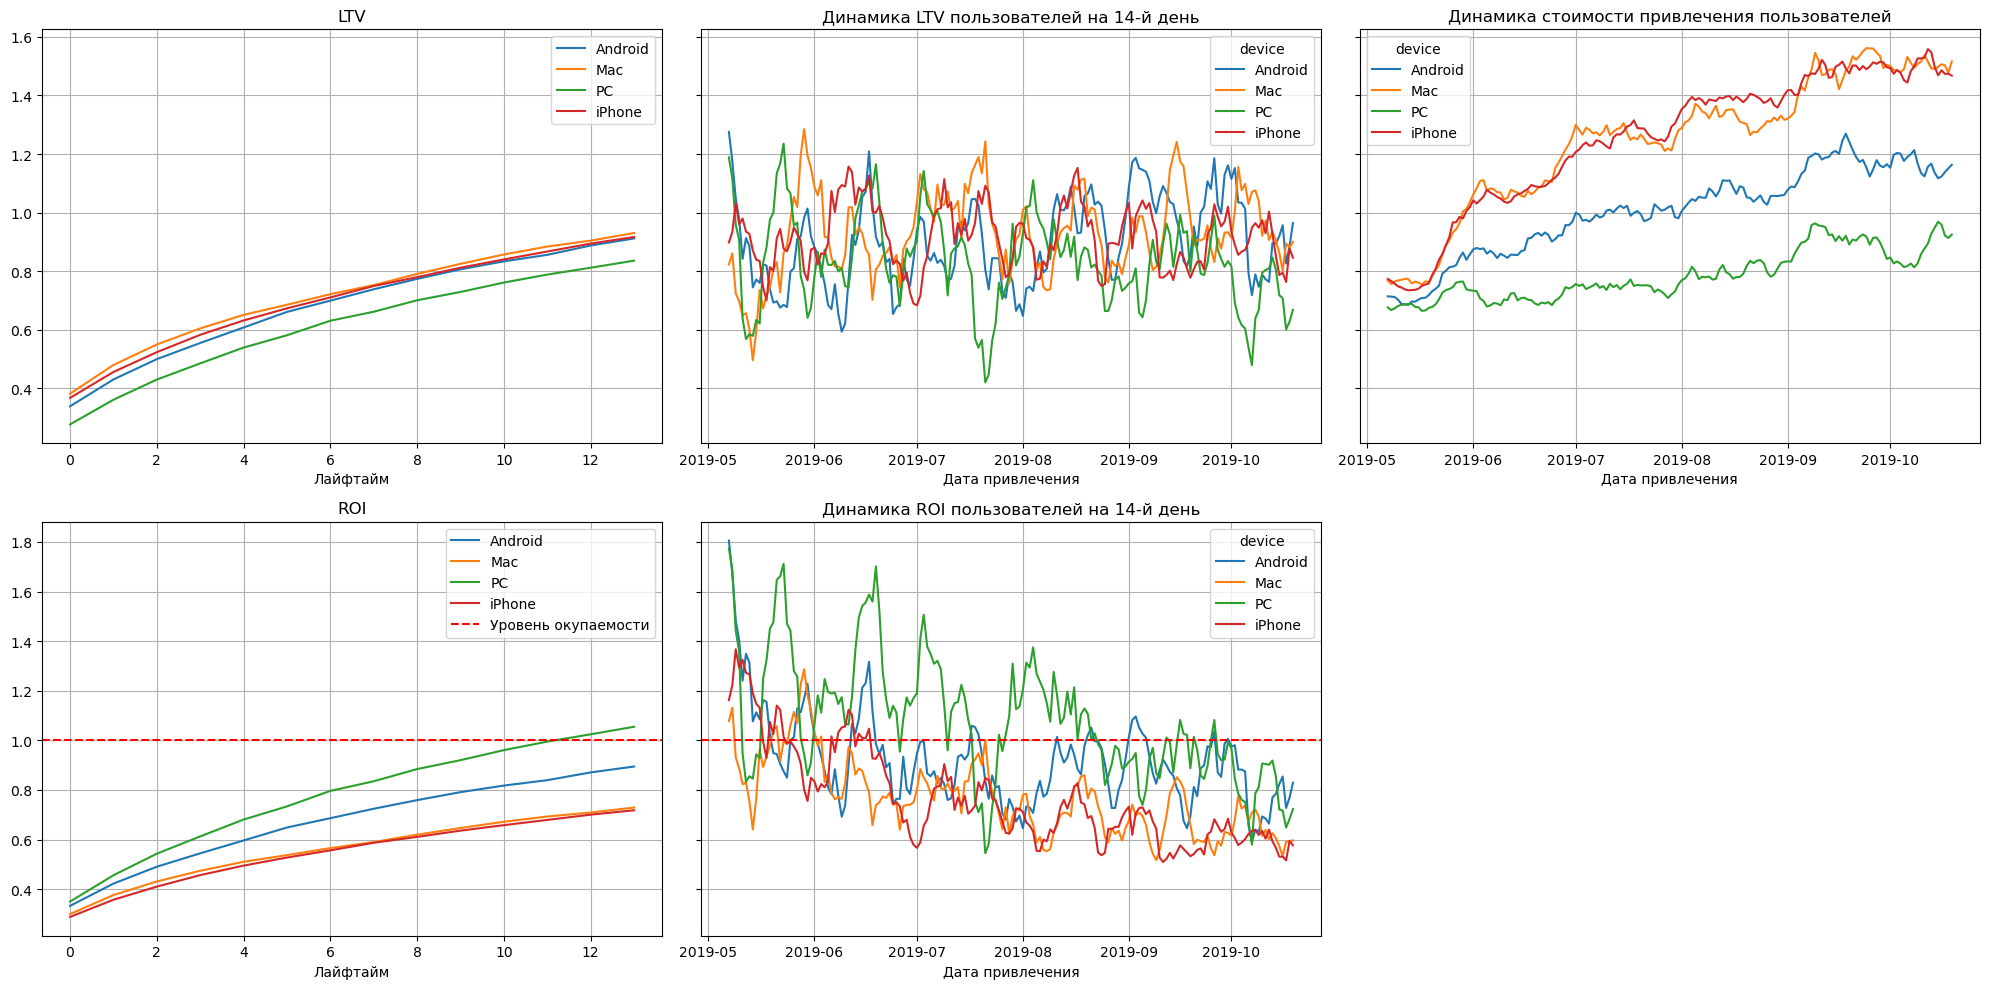

In [37]:
# считаем LTV и ROI с разбивкой по используемым устройствам
dimensions = ['device']
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики по данным без органических пользователей
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days) 

В разбивке по устройствам к концу лайфтайма окупаемости достигает только пользователи персональных компьютеров (PC), а прибыли на одного пользователя они приносят меньше всего. И все это при том, что доля платящих пользователей меньше всего с данного устройства (анализировали выше).

Пользователи остальных устройств не окупаются, при этом, начиная с сентября пользователи приложения с устройств PC тоже почти не окупаются.

Затраты по всем устройствам планомерно растут, окупаемость пользователей к концу рассматриваемого периода равномерно падает.

Но ничего такого выдающегося нет, показатели по всем устройствам +- синхронны относительно друг друга.

При этом стоит помнить, что основная масса пользователей США использует технику aррle.

#### Анализ окупаемости рекламы с разбивкой по странам: 

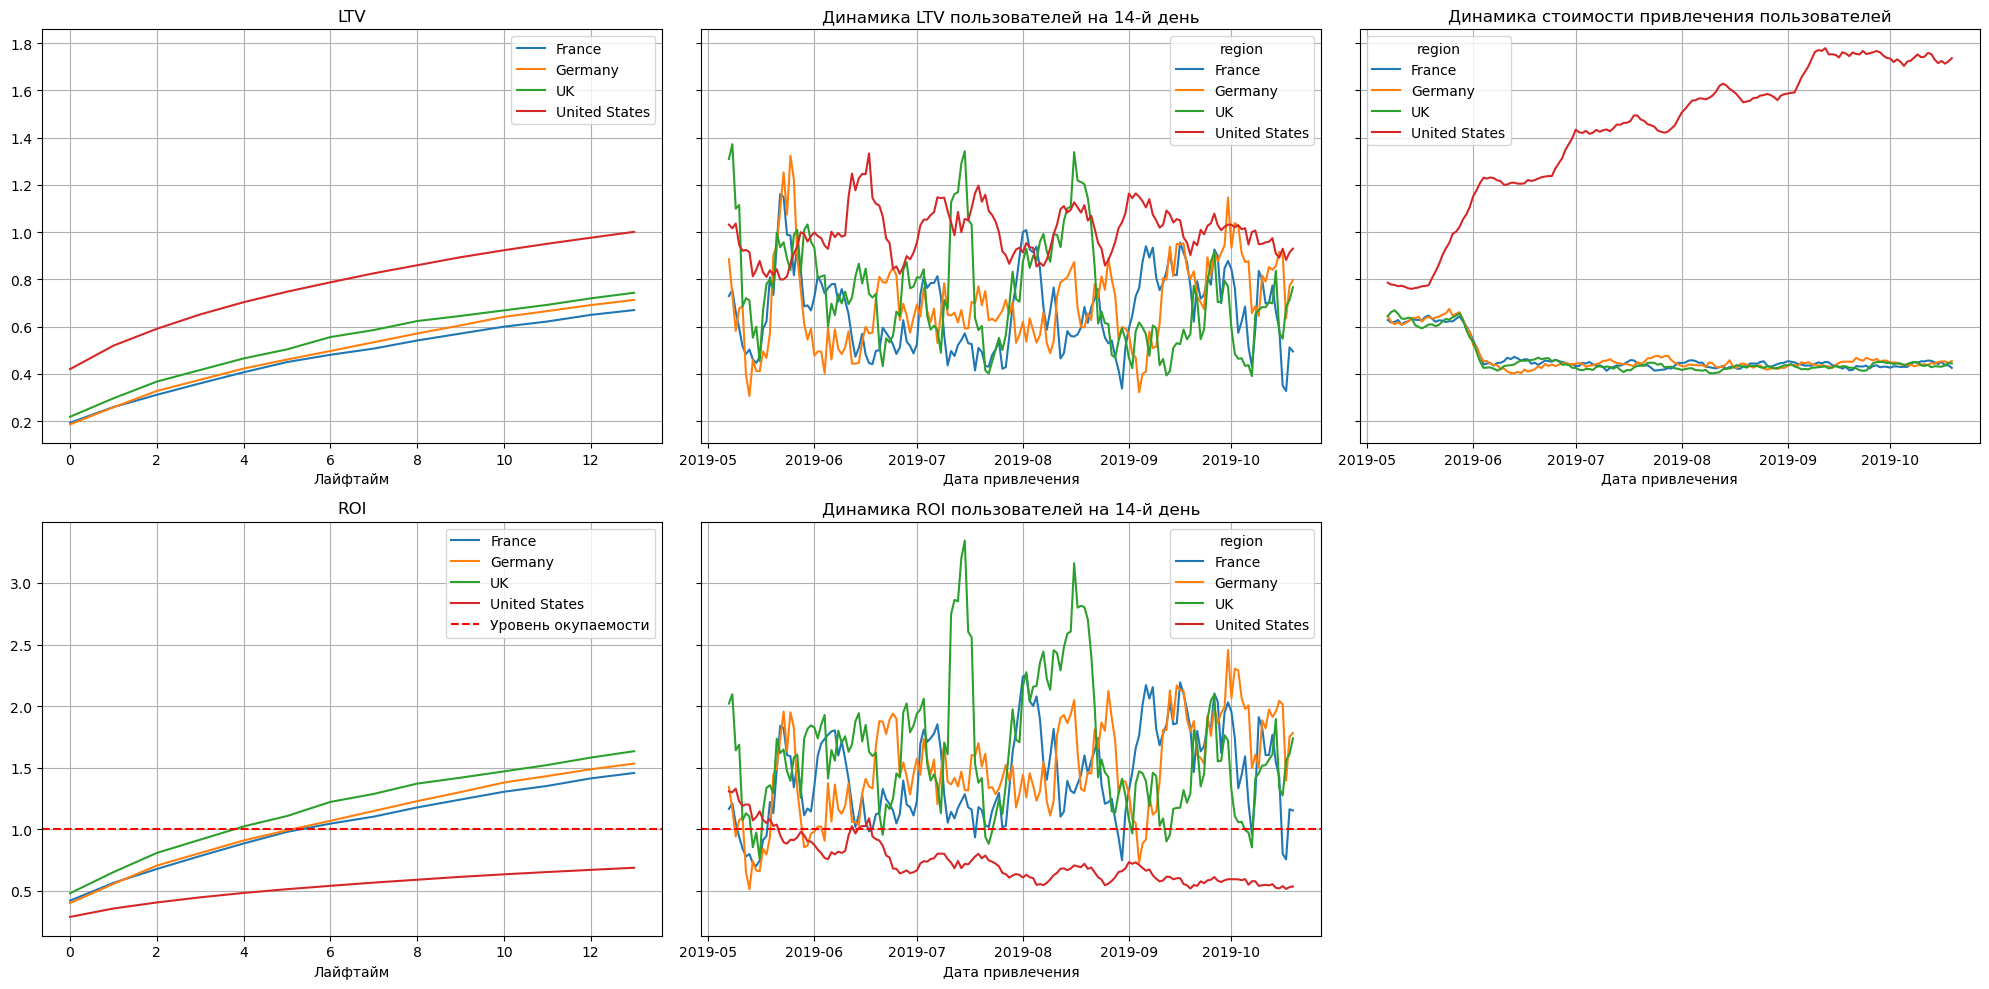

In [38]:
# считаем LTV и ROI с разбивкой по странам
dimensions = ['region']
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики по данным без органических пользователей
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days) 

Вот тут разко бросается в глаза США - очень высокие затраты! при том, что по всем другим странам затраты наоборот падают, именно вложения в США очень высокие и больше остальных где-то в 4,5 раза.

При этом пользователи США имеют самую высокую прибыль на одного пользователя, но это их все равно не спасает - уровня окупаемости они не достигают (окупаемость на конец лайфтайма около 70%). При этом в динамике окупаемость по данной стране только падает (в начале рассматриваемого периода вложения окупаются - ROI приблизительно равен 130%, а на конец октября окупаемость около 50%).

Пользователи остальных стран регулярно окупаются.

#### Анализ окупаемости рекламы с разбивкой по рекламным каналам:

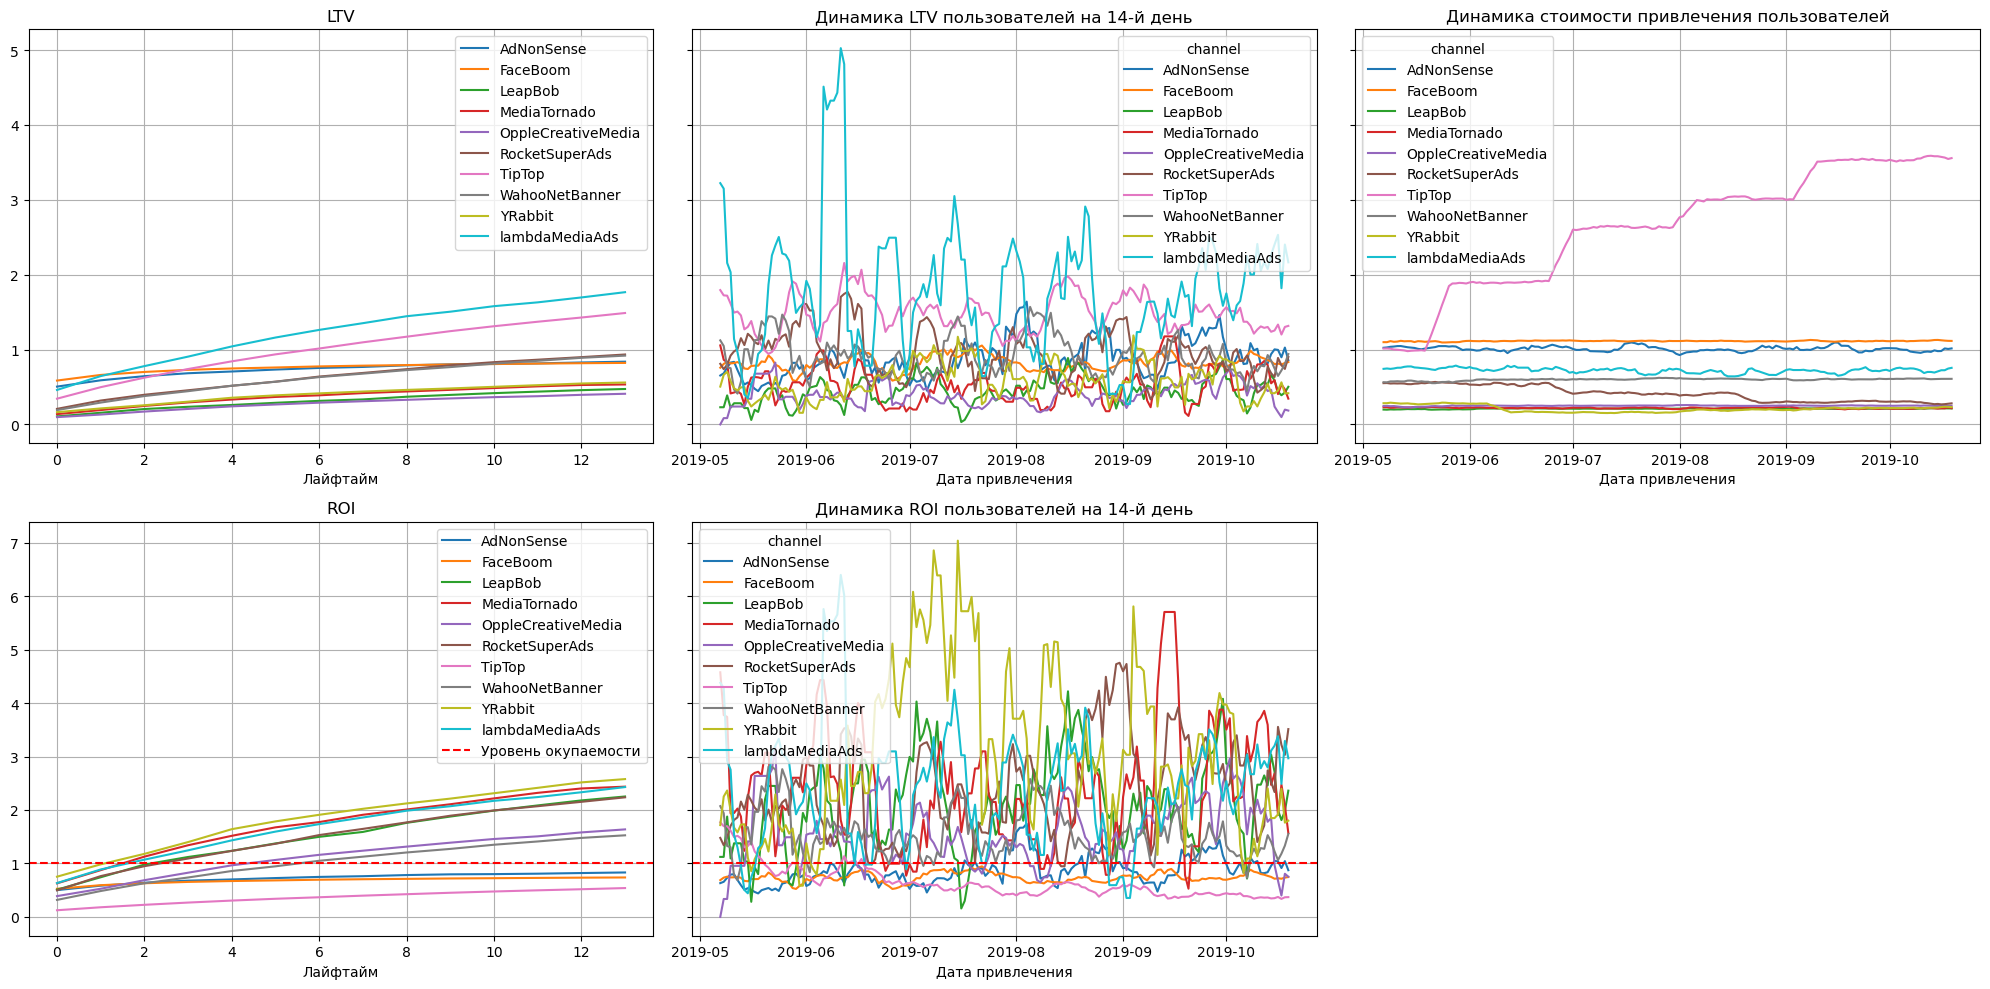

In [39]:
# считаем LTV и ROI с разбивкой по каналам привлечения
dimensions = ['channel']
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики по данным без органических пользователей
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days) 

По каналам тоже виден явный отрыв по затратам на "популярный" в рамках нашего исследования канал - TipTop. Затраты на пользователей в рамках данного канала выше относительно других почти в 3,5 раза. И при этом данный канал не достигает окупаемости, хоть и LTV высокий относительно других каналов.

Еще стоит отметить, что во втором канале, который лидирует по количеству вложений в него - FaceBoom на протяжении всего рассматриваемого периода ROI меньше 1.

Также можно еще отметить канал привлечения AdNonSense - вложения в него чуть меньше, чем в FaceBoom, но он в среднем не достигает уровня окупаемости к концу лайфтайма, но в динамике иногда бывает выше уровня окупаемости.

Кроме того, графики динамики стоимости привлечения пользователей по странам и каналам привлечения очень схожи.

Хорошо себя проявляют пользователи, пришедшие из канала lambdaMediaAds - по ним и высокая прибыль и окупаемость достигается уже на 2-й день лайфтайма. Ранее мы его упоминали среди тех пользователей, которые лучше всего конвертируются.

Еще раз стоит отметить, что только по каналу TipTop отмечается ежемесячный рост затрат на рекламу, а по всем они довольно стабильны. Причем по каналу TipTop и хорошие показатели по конверсии, и хорошие показатели по удержанию. Может, стоит порекомендовать отделу рекламу не вкладывать туда так много трат и посмотреть, что будет.

Получается, что дорогие каналы не окупаются, а по всем остальным каналам привлечения прибыль, может, и не такая высокая как у lambdaMediaAds, но они все же окупаются.

**Можно предположить, что основная часть пользователей, привлеченных из канала TipTop, являются жителями США. Возможно, такая же ситуации и относительно и двух других убыточных каналов привлечения - FaceBoom и AdNonSense. Проверим это:**

In [40]:
#сгрппипуем профили пользователей (profiles) по странам и каналам привлечения (убрав из них органичеких пользователей)
#посчитаем сколько пользователей по каждому каналу в каждой стране
profiles.query(
    'channel != "organic"'
    ).groupby(['region','channel']
    ).agg({'channel': 'count'}
    ).rename(columns = {'channel': 'channel_count'}
    ).sort_values(by = ['region', 'channel_count'], ascending = False) #отсортируем кол-во пользователей в порядке убывания

channel_count
region        channel                          
United States FaceBoom                    29144
              TipTop                      19561
              RocketSuperAds               4448
              MediaTornado                 4364
              YRabbit                      4312
UK            OppleCreativeMedia           3052
              LeapBob                      3046
              WahooNetBanner               3003
              AdNonSense                   1295
              lambdaMediaAds                758
Germany       WahooNetBanner               2579
              OppleCreativeMedia           2562
              LeapBob                      2519
              AdNonSense                   1219
              lambdaMediaAds                649
France        OppleCreativeMedia           2991
              LeapBob                      2988
              WahooNetBanner               2971
              AdNonSense                   1366
              lambdaMediaAds                742

Наши предположения относительно каналов TipTop и FaceBoom подтвердились. Более того, данные каналы привлечения есть только в США. Теперь понятно почему они так тянут на дно в части окупаемости данный регион.


**Ниже проверим какая была бы окупаемость у США без каналов привлечения TipTop и FaceBoom.**

А вот канал AdNonSense есть во всех остальных странах кроме США. Но, учитывая, что пользователи из других стран все равно, как правило окупаются, для них необязательно проводить такую проверку, можно будет просто сказать маркетолагам, что этот канал убыточен.

**Приступаем к проверке:**

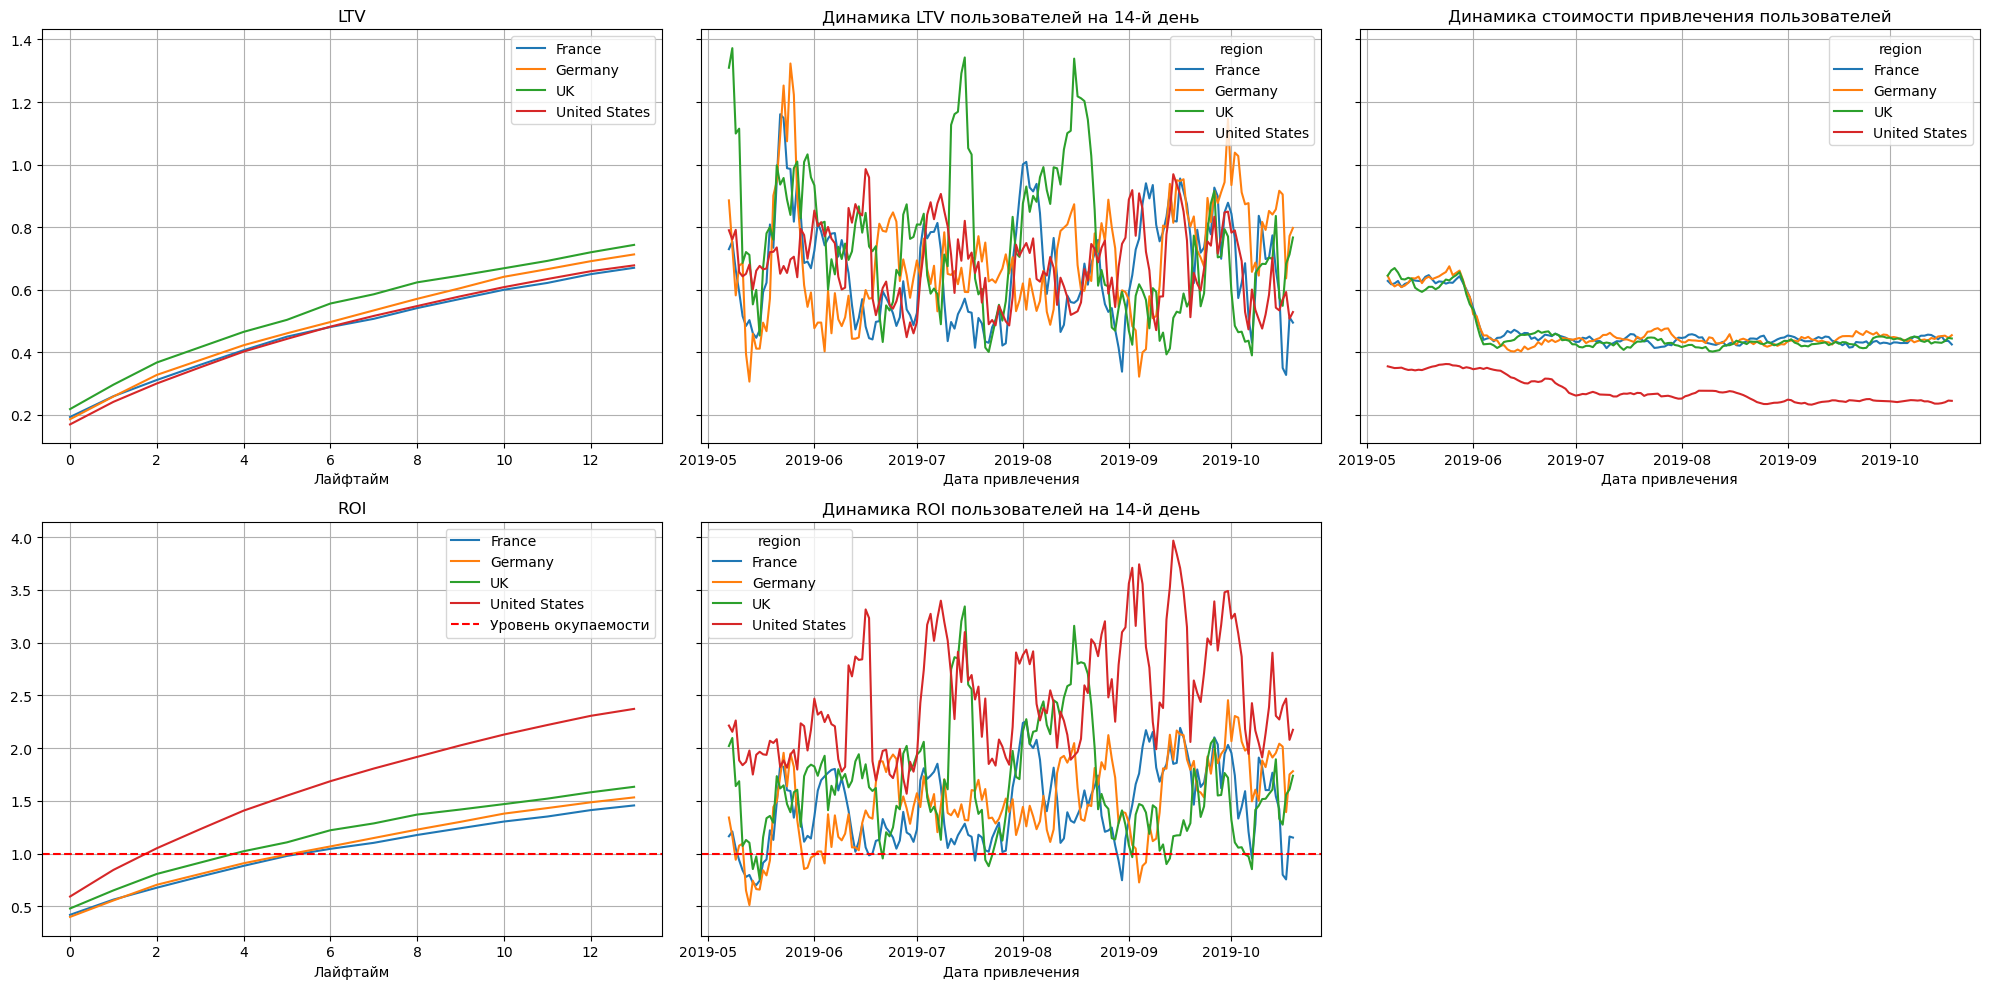

In [41]:
# считаем LTV и ROI с разбивкой по странам
dimensions = ['region']
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != ["organic", "TipTop", "FaceBoom"]'), #доп-но исключаем каналы привления TipTop и FaceBoom
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days) 

**Сбросив этот балласт США приносили бы большие прибыли компании вместо убытков!**

**Еще можно посмотреть почему же все таки так провальны по окупаемости пользователи приложнения, которые используют устройства iPhone и Mac.**

Как мы помним затраты по ним были больше всех и окупаемость самая низкая:
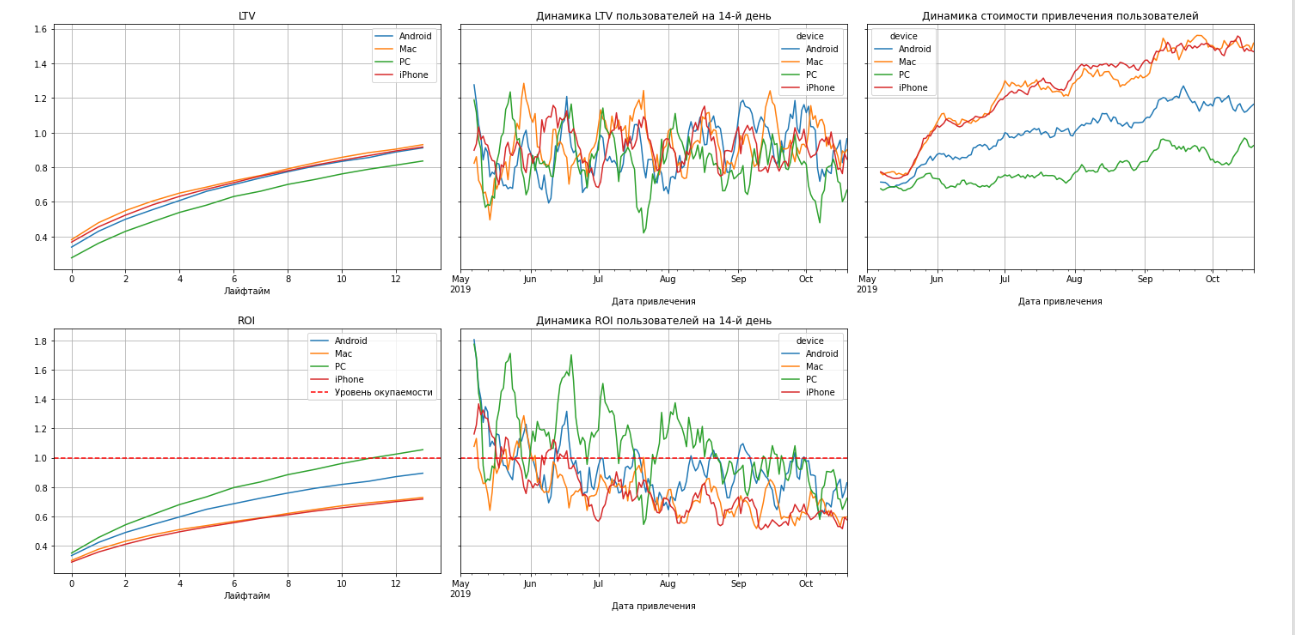

Причем ранее мы отмечали, что пользоваели именно этих устройств имели больше всего платящих пользователей.

Сперва разделим всех пользователей, на тех, кто пользуется устройствами IOS и остальных:

In [42]:
#заменим всех пользователей, использующих Mac и iPhone на "IOS", а всех остальных на "another"
profiles['categorize_device'] = profiles['device'].copy(
    ).replace(
    ['Mac', 'iPhone', 'Android', 'PC'],
    ['IOS', 'IOS', 'another', 'another']
)

profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost categorize_device  
0  2019-05-07 2019-05-01   True          1.088172               IOS  
1  2019-07-09 2019-07-01  False          1.107237               IOS  
2  2019-10-01 2019-10-01  False          0.000000               IOS  
3  2019-08-22 2019-08-01  False          0.988235           another  
4  2019-10-02 2019-10-01  False          0.230769               IOS

Теперь разделим каналы привлечения пользователей: на тех, кто пришел из TipTop и FaceBoom и остальных:

In [43]:
#создадим функцию, которая преобразовывает все значения столбца там, где нет TipTop или FaceBoom на "another"
def categorize_channel(row):
        if 'TipTop' in row:
            return 'TipTop'
        elif 'FaceBoom' in row:
            return 'FaceBoom'
        else:
            return 'another'
    
#применим получившуюся функцию
profiles['categorize_channel'] = profiles['channel'].apply(categorize_channel)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost categorize_device  \
0  2019-05-07 2019-05-01   True          1.088172               IOS   
1  2019-07-09 2019-07-01  False          1.107237               IOS   
2  2019-10-01 2019-10-01  False          0.000000               IOS   
3  2019-08-22 2019-08-01  False          0.988235           another   
4  2019-10-02 2019-10-01  False          0.230769               IOS   

  categorize_channel  
0           FaceBoom  
1           FaceBoom  
2            another  
3            another  
4            another

Теперь построим сводную таблицу и посмотрим как распределяются пользователи, пришедших из каналов FaceBoom, TipTop и всех остальных в зависимости от используемого устройства:

In [44]:
#строим сводную таблицу
profiles.pivot_table(
    index = 'categorize_device',
    columns = 'categorize_channel',
    values = 'user_id',
    aggfunc = 'count',
    margins = True
)

categorize_channel  FaceBoom  TipTop  another     All
categorize_device                                    
IOS                    20261   13660    50600   84521
another                 8883    5901    50703   65487
All                    29144   19561   101303  150008

Как видим основная часть пользователей, пришедших из какналов FaceBoom и TipTop используют в большей мере устройства для покупки из категории IOS (20 261 + 13 660 = 33 9218 или почти 70% против 8 883 + 5 901 = 14 784). Причем пользователи, пришедшие из остальных каналов привлечения распределяются по используемым устройствам почти поровну (IOS = 50 600, another = 50 703).

Может быть, по этой причине как раз и падала окупаемость этих устройств, чуть позже посмотрим на графиках.

А сперва посмотрим какова была доля платящих среди пользователей, пришедших из каналов FaceBoom и TipTop и использующих устройства IOS:

In [45]:
#группируем пользователей по категориям используемых устройств и каналам откуда они пришли+
profiles.groupby(
    ['categorize_device', 'categorize_channel']
    ).agg(
    {
        'categorize_channel': 'count', #находим сумму пользователей в каждом канале привлечения
        'payer': 'mean' #считаем долю платящих пользователей
    }
)

categorize_channel     payer
categorize_device categorize_channel                              
IOS               FaceBoom                         20261  0.119244
                  TipTop                           13660  0.092679
                  another                          50600  0.031858
another           FaceBoom                          8883  0.128448
                  TipTop                            5901  0.103711
                  another                          50703  0.036171

Платящие пользователи распределились поровну, поэтому дело не в их количестве, а просто в том, что эти каналы дорогостоящие.

Вернемся к визуализации графиков ROI и LTV по устройствам без каналов FaceBoom и TipTop:

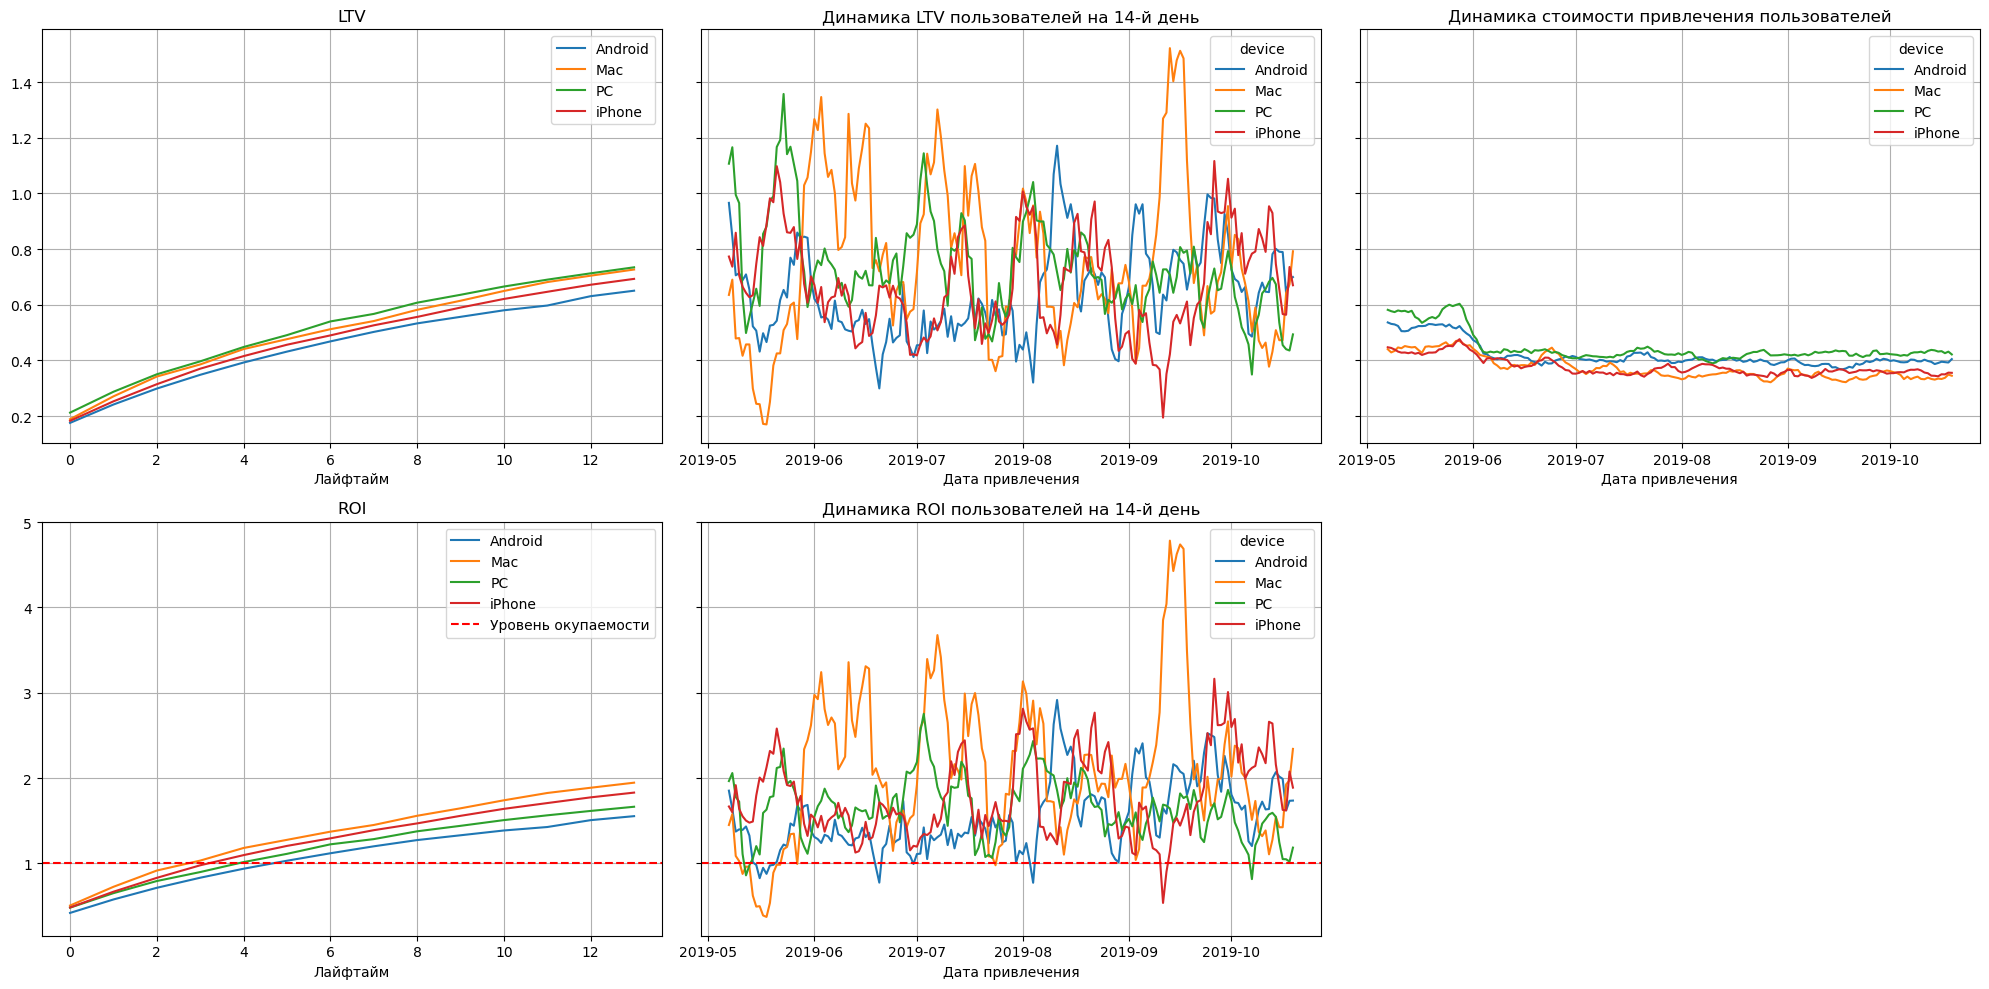

In [46]:
# считаем LTV и ROI с разбивкой по используемым устройствам
dimensions = ['device']
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != ["organic", "FaceBoom", "TipTop"]'), #исключив каналы привлечения FaceBoom и TipTop
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

# строим графики по данным без органических пользователей
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days)

Вот тогда картина сразу меняется, пользователи всех устройств выходят в плюс.

**Вернемся тогда к общей окупаемости всего приложения без разбивки по каким-либо критерям. Только уберем оттуда каналы привлечения FaceBoom и TipTop и посмотрим, что выйдет:**

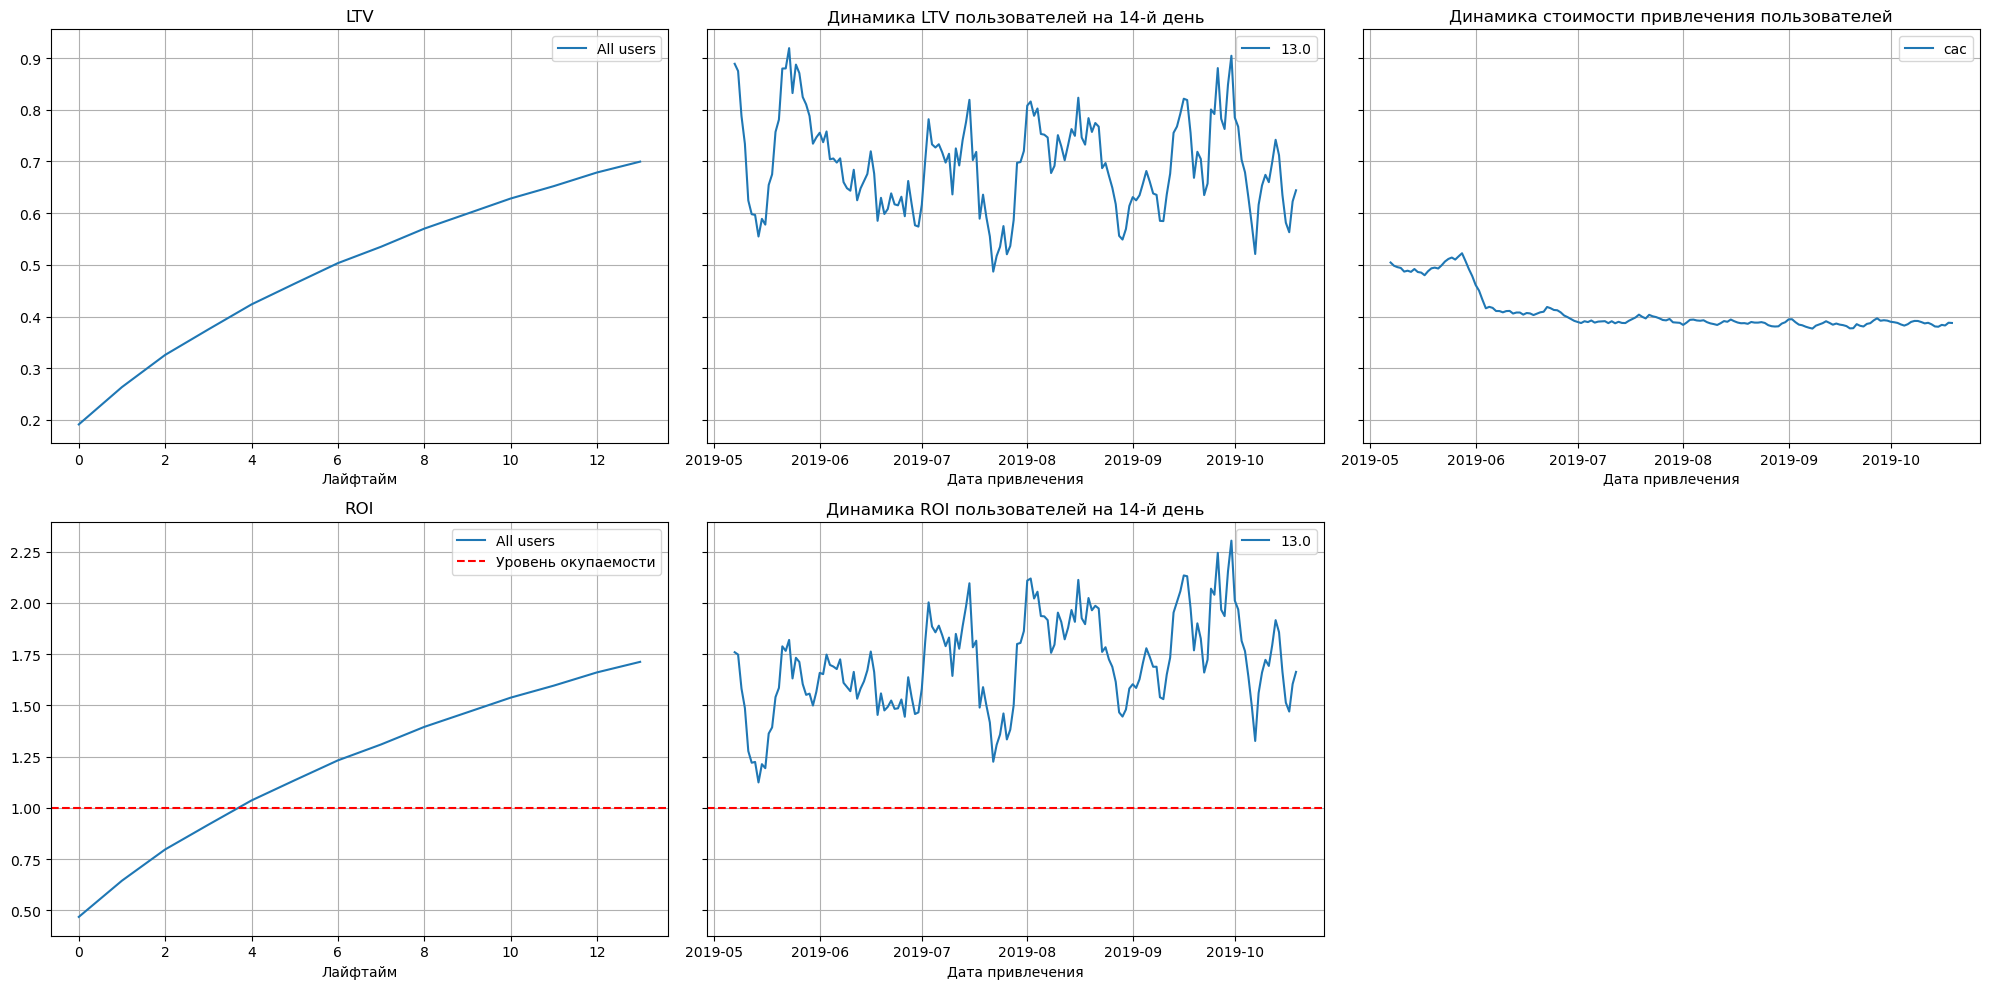

In [47]:
# считаем LTV и ROI без пользователей, привлеченных из FaceBoom и TipTop, а также и без органических пользователей
ltv_raw_no_org, ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org = get_ltv(
    profiles.query('channel != ["organic", "FaceBoom", "TipTop"]'), orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped_no_org, ltv_history_no_org, roi_grouped_no_org, roi_history_no_org, horizon_days) 

**Вот теперь картина очень хорошая. Окупаемость наступает уже на 4 лайфтайм, а в динамике по месяцам приложение всегда окупается.**

**Выводы:**
* в настоящее время затраты на рекламу еле достигает значения окупаемости, можно сказать что выходим в ноль на 14-й день лайфтайма и то, благодаря органическим пользователям, без них окупаемости вообще нет.
* существенные траты осуществляются в такие каналы привлечения пользователей как FaceBoom и TipTop, динамика трат только растет, как следствие они не окупаются, почти с самого начала рассматриваемого периода.
* каналы FaceBoom и TipTop привлекают пользователей, только из США, поэтому и затраты на пользователей из данной страны не окупаются.
* основная часть пользователей, привлеченных из каналов FaceBoom и TipTop пользуется устройствами iPhone и Mac, поэтому окупаемость по ним тоже не достигается на протяжении всего лайфтайма.
* AdNonSense - это еще один канал привлечения пользователей, который тоже с низкой окупаемостью, но он расположен во всех остальных анализируемых регионах кроме США.

Рекламному отделу можно дать следующие рекомендации:
* сократить вложения в канал TipTop, у него довольно хорошие показатели удержания и конверсии, может быть, и не нужны доп. вложения. По итогам стоит провести повторный анализ стали ли затраты в этот канал окупаться. Если все так и останется, то, может быть, рассмотреть возможность его закрытия.
* по каналу FaceBoom нужно понять в чем причина плохого удержания пользователей при том, что конвертируются они хорошо. Затраты по данному каналу не растут, а значит, если исправить вопрос с удержанием, то, скорее всего, можно рассчитывать и на последующую окупаемость вложений по данному каналу. Аналогичная ситуация с каналом AdNonSense, по нему тоже рекомендуется подумать над причиной низкого удержания пользователей.
* очень хорошо конвертируются, удерживаются, приносят прибыль и окупаются пользователи, привлеченные из канала lambdaMediaAds (популярен во всех странах, кроме США). Может быть, стоит рассмотреть чуть увеличить траты в этот канал и посмотреть какая будет отдача. В целом, по остальным каналам привлечения, и в особенности RocketSuperAds, MediaTornado, YRabbit (каналы США), тоже можно чуть поэксперемнтировать с вложениями в рекламную компанию и посмотреть какой будет результат: сильно ли увеличится прибыль и каков тогда будет срок окупаемости.

### Общий вывод и рекомендации
<a id="conclusion"></a> 

**В этоим исследовании мы:**
- рассмотрели данные в первоначальном виде и выявили какие данные стоит преобразовать, обратить на них внимание
- сделали предобработку данных:
```
 - сделали проверку на пропуски;
 - изменили типы данных там, где это требуется;
 - осуществили проверку на дубликаты.
```
- задали функции для:
```
 - создания профилей, расчёта удержания, конверсии, LTV и ROI;
 - визуализации этих метрик.
```
- исследовали откуда приходят пользователи (страны и рекламные каналы привлечения), а также какими устройствами они пользуются
- исследовали какова общая стоимость привлечения пользователей из различных рекламных каналов
- визуализировали динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику, а также определили сколько в среднем стоило привлечение одного пользователя из каждого источника
- оценили окупаемость рекламы:
```
 - в целом;
 - и в зависимости от характеристик пользователей (страна, используемое устройство, канал привлечения).
```
- выявили проблемы окупаемости, которые приводили к убыткам.
 
 **И пришли к следующим выводам:**
 1. Больше всего пользователей приходит из США (100 тыс.), меньше всего - из Германии (14 тыс.). При этом наибольшая доля платящих пользователей расположена в США (6,9%), а наименьшая - во Франции (3,7%). 
```
``` 
 2. Как правило пользователи оплачивают покупки с таких устройств как Mac (6,3% доля платящих клиентов среди использующих Mac) и iPhone (6,2% доля платящих клиентов среди использующих iPhone). Меньше всего платящих пользователей приходится на пользователей использующих PC (5%).
```
``` 
 3. Наибольшее количество платящих пользователей приходит из канала FaceBoom (12,2%). Наименьшее количество платящих пользователей из канала приходитмя на органических пользователей (2,0%).
```
```
 4. Больше всего пользователей приложением привлечены из канала organic (56 тыс.), затем из FaceBoom (29 тыс.) и TipTop (19 тыс.).
```
``` 
 5. В каналах TipTop и FaceBoom самые большие затраты на рекламу. Кроме того, эти каналы имеют большой отрыв по затратам от всех остальных каналов - в совокупности на них приходится около 82% всех затрат
```
``` 
 6. Затраты на рекламу почти что окупаются (выходим в ноль на 14-й день лайфтайма) - такие данные получаем с учетом органических пользователей. Без учета органических пользователей окупаемость отсутствует.
```
```  
 7. Динамика трат по каналу привлечения пользователей TipTop ежемесячно растет и, как следствие, пользователи из данного канала  не окупаются. При этом у пользователей из данного канала хорошая конверсия и удержание. По каналу Faceboom тоже высокие траты, но они стабильны, конверсия хорошая, а вот удержание очень низкое, из-за чего канал не успевает окупаться. Эти 2 канала привлекают пользователей, только из США, поэтому и затраты на пользователей из США тоже не окупаются. В итоге не окупаемые вложения в эти 2 канала привлечения пользователей существенно снижают общую окупаемость проекта.
```
``` 
 8. Основная часть пользователей, привлеченных из каналов FaceBoom и TipTop пользуется устройствами iPhone и Mac, поэтому окупаемость по ним тоже не достигается на протяжении всего лайфтайма.
```
``` 
 9. AdNonSense - это еще один канал привлечения пользователей, который тоже с низкой окупаемостью, но он расположен во всех остальных анализируемых регионах кроме США. У него очень схожа ситуация с каналом FaceBoom: хорошая конверсия, низкое удержание, стаблиные затраты, нет окупаемости. Стоит разобраться в причинах низкого удержания.
    
**Общие рекомендации рекламному отделу:**
* сократить вложения в канал TipTop, у него довольно хорошие показатели удержания и конверсии, может быть, и не нужны доп. вложения. По итогам стоит провести повторный анализ стали ли затраты в этот канал окупаться. Если все так и останется, то, может быть, рассмотреть возможность его закрытия.
* по каналу FaceBoom нужно понять в чем причина плохого удержания пользователей при том, что конвертируются они хорошо. Затраты по данному каналу не растут, а значит, если исправить вопрос с удержанием, то, скорее всего, можно рассчитывать и на последующую окупаемость вложений по данному каналу. Также можно настроить более таргетированное привлечение, направленное на пользователей с необходимыми характеристиками, ввести поощрение пользователей за репосты контента и прочий социальный engagement, связанный с приложением, в данном канале. Аналогичная ситуация с каналом AdNonSense, по нему тоже рекомендуется подумать над причиной низкого удержания пользователей.
* очень хорошо конвертируются, удерживаются, приносят прибыль и окупаются пользователи, привлеченные из канала lambdaMediaAds (популярен во всех странах, кроме США). Может быть, стоит рассмотреть чуть увеличить траты в этот канал и посмотреть какая будет отдача. В целом, по остальным каналам привлечения, и в особенности RocketSuperAds, MediaTornado, YRabbit (каналы США), тоже можно чуть поэксперемнтировать с вложениями в рекламную компанию и посмотреть какой будет результат: сильно ли увеличится прибыль и каков тогда будет срок окупаемости.
* повысить удержание для пользователей из США, например с помощью введения персонализированных UX-стратегий, e-mail рассылок, персональных рекомендаций, push-уведомлений. Можно ввести определённые "награды" или привилегии для постоянных пользователей. 